In [44]:
import numpy as np
import os
from oe_acute import trial_utils as tu
from oe_acute import MNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import tqdm
import glob

import sys
from oe_acute import pyMNE

In [45]:
os.nice(1)

2

### Load dsets

In [3]:
stim_spec = np.load('/mnt/cube/srrudrar/temporal_model/stim_resp_64x64_256/enc_train_256.npy')
stim_resp_all = np.load('/mnt/cube/srrudrar/temporal_model/stim_resp_64x64_256/resp_train_256.npy')

In [19]:
ind = [165, 16, 191, 114, 12, 50, 96, 38, 211, 82, 130, 76, 142, 102, 107, 159, 156,
       66, 67, 206, 110, 93, 122, 125, 187, 68, 80, 81, 205, 147, 186, 63, 170, 51,
       2, 128, 41, 207, 35, 11, 21, 183, 112, 145, 53, 209, 57, 75, 31, 33]

In [20]:
stim_resp = stim_resp_all[:,ind,:]

In [21]:
np.shape(stim_spec), np.shape(stim_resp)

((54387, 256), (54387, 50, 64))

In [22]:
def prepare_MNE_dset(stim_spec, stim_resp, nsegbins=64, concat=True):
    '''
    Create the dataset for fitting MNE model
    '''
    stim_mne = []
    resp_mne = []
    for s, r in zip(stim_spec, stim_resp):
        #nfreq, ntime = s.shape
        #s_segs = np.stack([s[:, n:(n+nsegbins)] for n in range(ntime - nsegbins)], axis=0)
        s_segs = s
        r_segs = np.sum(r, axis=1)
        stim_mne.append(s_segs)
        resp_mne.append(r_segs)
    if concat:
        return np.vstack(stim_mne), np.vstack(resp_mne)
    else:
        return stim_mne, resp_mne

In [23]:
nsegbins = 64

In [24]:
stim_mne = []
resp_mne = []
stim_mne, resp_mne = prepare_MNE_dset(stim_spec, stim_resp, nsegbins=nsegbins)

In [25]:
np.shape(stim_mne), np.shape(resp_mne)

((54387, 256), (54387, 50))

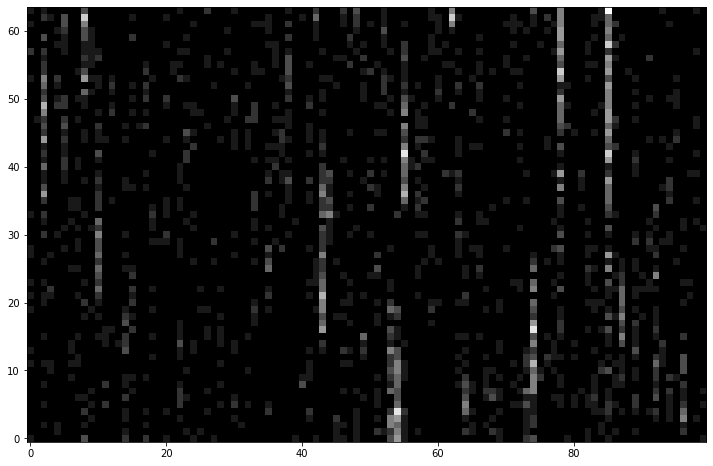

In [28]:
ax = plt.subplots(figsize=(20,8))
plt.imshow(np.transpose(stim_resp[:100, 20, :]), origin='lower', cmap='gray')

### Split into train test sets

In [29]:
len_units = np.shape(resp_mne)[1]

In [36]:
units_to_process_all = np.load('/mnt/cube/srrudrar/temporal_model/units_to_process.npy')
units_to_process = list(units_to_process_all[ind])

In [42]:
exp_path = '/mnt/cube/srrudrar/temporal_model/stim_resp_64x64_256/'

In [43]:
# obtain all preprocessed datas

%matplotlib inline
sdim = 256
n_jackknives = 4

test_output_path = os.path.join(exp_path, 'MNE_test_dset')
os.makedirs(test_output_path, exist_ok=True)
n_eigvec_to_display = 6 # Number of most positive and most negative eigenvectors to display

pfinals = {}
for unit in units_to_process:
    i = units_to_process.index(unit)
    stims_train, resps_train, stims_test, resps_test = MNE.prepare_MNE_train_test_set(stim_mne, resp_mne[:,i][:,np.newaxis], train_pct=0.8, zscore=True, kz_norm_resp=True)
    
    # Save test dataset
    test_dict = {'stims_test':stims_test, 'resps_test':resps_test}
    out_fname = 'unit-{}_MNE.pkl'.format(unit)
    out_f = os.path.join(test_output_path, out_fname)
    with open(out_f, 'wb') as f:
        pickle.dump(test_dict, f)

    # Run MNE
    pfinal = MNE.fit_MNE(stims_train, resps_train, order=2)
    #MNE.plot_MNE(pfinal, unit, figure_output_path)
    pfinals[unit] = pfinal

Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.153340
    2       0    0.149544
    3       0    0.147514
    4       0    0.145599
    5       0    0.144874
    6       0    0.144061
    7       0    0.143240
    8       0    0.142579
    9       0    0.142354
   10       0    0.141424
   11       0    0.141098
   12       0    0.140532
   13       0    0.140186
   14       0    0.140056
   15       0    0.139921
   16       0    0.139619
   17       0    0.139322
   18       0    0.139159
   19       0    0.139051
   20       0    0.138342
   21       0    0.138066
   22       0    0.137996
   23       0    0.137791
   24       0    0.137696
   25       0    0.137587
   26       0    0.137217
   27       0    0.137085
   28       0    0.136851
   29       0    0.136757
   30       0    0.135914
   31       0    0.135744
   32       0    0.135624
   33       0    0.135586
   34       0    0.135481
   35       0    0.135444
   36       0    0.135433
   37       0    0.135225
   38       0    0.135084
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.150424
    2       0    0.147313
    3       0    0.145297
    4       0    0.143731
    5       0    0.143097
    6       0    0.141677
    7       0    0.141502
    8       0    0.141173
    9       0    0.140543
   10       0    0.140310
   11       0    0.139865
   12       0    0.139500
   13       0    0.139083
   14       0    0.138698
   15       0    0.138502
   16       0    0.138283
   17       0    0.137892
   18       0    0.137629
   19       0    0.137454
   20       0    0.137120
   21       0    0.136887
   22       0    0.136738
   23       0    0.136379
   24       0    0.136117
   25       0    0.136017
   26       0    0.135951
   27       0    0.135869
   28       0    0.135740
   29       0    0.135597
   30       0    0.135452
   31       0    0.135132
   32       0    0.134677
   33       0    0.134452
   34       0    0.134191
   35       0    0.133960
   36       0    0.133926
   37       0    0.133869
   38       0    0.133823
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.152383
    2       0    0.148793
    3       0    0.146041
    4       0    0.144900
    5       0    0.144413
    6       0    0.143523
    7       0    0.143204
    8       0    0.142672
    9       0    0.142477
   10       0    0.141900
   11       0    0.141625
   12       0    0.140545
   13       0    0.139979
   14       0    0.139379
   15       0    0.138890
   16       0    0.138686
   17       0    0.138442
   18       0    0.138290
   19       0    0.138248
   20       0    0.138070
   21       0    0.137967
   22       0    0.137755
   23       0    0.137561
   24       0    0.137005
   25       0    0.136887
   26       0    0.136632
   27       0    0.136337
   28       0    0.136279
   29       0    0.136213
   30       0    0.136181
   31       0    0.136136
   32       0    0.135996
   33       0    0.135946
   34       0    0.135860
   35       0    0.135804
   36       0    0.135711
   37       0    0.135619
   38       0    0.135570
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.153502
    2       0    0.149996
    3       0    0.148105
    4       0    0.146270
    5       0    0.145706
    6       0    0.143213
    7       0    0.142551
    8       0    0.141587
    9       0    0.140993
   10       0    0.140675
   11       0    0.139851
   12       0    0.139447
   13       0    0.139244
   14       0    0.138943
   15       0    0.138773
   16       0    0.138146
   17       0    0.137935
   18       0    0.137841
   19       0    0.137778
   20       0    0.137613
   21       0    0.137611
   22       0    0.137461
   23       0    0.137345
   24       0    0.136942
   25       0    0.136778
   26       0    0.136577
   27       0    0.136540
   28       0    0.136078
   29       0    0.136038
   30       0    0.135923
   31       0    0.135833
   32       0    0.135755
   33       0    0.135720
   34       0    0.135554
   35       0    0.135380
   36       0    0.135246
   37       0    0.135217
   38       0    0.135117
   39       

   41       0    0.144501
   42       0    0.144364
   43       0    0.144126
   44       0    0.144030
   45       0    0.143731
   46       0    0.143639
   47       0    0.143555
   48       0    0.143556
   49       1    0.143559
   50       2    0.143483
   51       0    0.143456
   52       0    0.143379
   53       0    0.143329
   54       0    0.143294
   55       0    0.143246
   56       0    0.143214
   57       0    0.143185
   58       0    0.143164
   59       0    0.143163
   60       0    0.143182
   61       1    0.143166
   62       2    0.143148
   63       0    0.143118
   64       0    0.143113
   65       0    0.143074
   66       0    0.143063
   67       0    0.143032
   68       0    0.143025
   69       0    0.142911
   70       0    0.142727
   71       0    0.142666
   72       0    0.142378
   73       0    0.142333
   74       0    0.142369
   75       1    0.142289
   76       0    0.142258
   77       0    0.142244
   78       0    0.142206
   79       

    6       0    0.270746
    7       0    0.268925
    8       0    0.266755
    9       0    0.265855
   10       0    0.264718
   11       0    0.264345
   12       0    0.263381
   13       0    0.262421
   14       0    0.261977
   15       0    0.261137
   16       0    0.260742
   17       0    0.259643
   18       0    0.259263
   19       0    0.258081
   20       0    0.257526
   21       0    0.257040
   22       0    0.256742
   23       0    0.256382
   24       0    0.256368
   25       0    0.256220
   26       0    0.256043
   27       0    0.255985
   28       0    0.255886
   29       0    0.255761
   30       0    0.255626
   31       0    0.255554
   32       0    0.255247
   33       0    0.255116
   34       0    0.254983
   35       0    0.254768
   36       0    0.254525
   37       0    0.254154
   38       0    0.253934
   39       0    0.253683
   40       0    0.253598
   41       0    0.253539
   42       0    0.253509
   43       0    0.253446
   44       

  112       0    0.247014
  113       1    0.246978
  114       0    0.246969
  115       0    0.246991
  116       1    0.246998
  117       2    0.246963
  118       0    0.246947
  119       0    0.247007
  120       1    0.247018
  121       2    0.247043
  122       3    0.247014
  123       4    0.247046
  124       5    0.247024
  125       6    0.246985
  126       7    0.246976
  127       8    0.246986
  128       9    0.246951
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.283698
    2       0    0.279643
    3       0    0.275422
    4       0    0.273393
    5       0    0.272062
    6       0    0.269319
    7       0    0.268260
    8       0    0.267724
    9       0    0.267537
   10       0    0.266555
   11       0    0.265595
   12       0    0.265048
   13       0    0.263853
   14       0    0.262990
   15       0    0.261640
   16       0    0.260198
   17       0    0.260075
   18       0    0.259582
   19       0    0.259141
   20       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.577619
    2       0    0.572984
    3       0    0.571557
    4       0    0.568197
    5       0    0.564206
    6       0    0.562973
    7       0    0.561308
    8       0    0.561026
    9       0    0.560345
   10       0    0.559330
   11       0    0.558767
   12       0    0.558120
   13       0    0.557735
   14       0    0.556633
   15       0    0.556173
   16       0    0.554803
   17       0    0.553837
   18       0    0.553281
   19       0    0.552858
   20       0    0.552477
   21       0    0.552196
   22       0    0.551786
   23       0    0.551354
   24       0    0.551117
   25       0    0.550846
   26       0    0.550817
   27       0    0.550790
   28       0    0.550667
   29       0    0.550531
   30       0    0.549993
   31       0    0.549662
   32       0    0.549573
   33       0    0.549168
   34       0    0.549105
   35       0    0.548981
   36       0    0.548958
   37       0    0.548964
   38       1    0.548837
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.576775
    2       0    0.571540
    3       0    0.570262
    4       0    0.566613
    5       0    0.563043
    6       0    0.561674
    7       0    0.559221
    8       0    0.558410
    9       0    0.557116
   10       0    0.555373
   11       0    0.554935
   12       0    0.554286
   13       0    0.553627
   14       0    0.553160
   15       0    0.552714
   16       0    0.552438
   17       0    0.552195
   18       0    0.551870
   19       0    0.551617
   20       0    0.551535
   21       0    0.551398
   22       0    0.551170
   23       0    0.550769
   24       0    0.550552
   25       0    0.549503
   26       0    0.548807
   27       0    0.548487
   28       0    0.548024
   29       0    0.547839
   30       0    0.547450
   31       0    0.547251
   32       0    0.546928
   33       0    0.546855
   34       0    0.546797
   35       0    0.546671
   36       0    0.546655
   37       0    0.546534
   38       0    0.546467
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.578304
    2       0    0.574126
    3       0    0.572265
    4       0    0.569095
    5       0    0.565134
    6       0    0.563955
    7       0    0.562376
    8       0    0.562009
    9       0    0.561559
   10       0    0.559772
   11       0    0.559511
   12       0    0.558383
   13       0    0.558046
   14       0    0.556717
   15       0    0.555054
   16       0    0.554379
   17       0    0.554198
   18       0    0.553675
   19       0    0.553410
   20       0    0.553236
   21       0    0.552762
   22       0    0.552416
   23       0    0.552131
   24       0    0.551871
   25       0    0.551824
   26       0    0.551643
   27       0    0.551309
   28       0    0.551069
   29       0    0.551001
   30       0    0.550894
   31       0    0.550636
   32       0    0.550589
   33       0    0.550456
   34       0    0.550329
   35       0    0.550232
   36       0    0.550025
   37       0    0.549962
   38       0    0.549570
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.576417
    2       0    0.571877
    3       0    0.570742
    4       0    0.566829
    5       0    0.563588
    6       0    0.562418
    7       0    0.560439
    8       0    0.559489
    9       0    0.558624
   10       0    0.558386
   11       0    0.557712
   12       0    0.556544
   13       0    0.556172
   14       0    0.555561
   15       0    0.554801
   16       0    0.554699
   17       0    0.554436
   18       0    0.553651
   19       0    0.553329
   20       0    0.552774
   21       0    0.552267
   22       0    0.551832
   23       0    0.551222
   24       0    0.551109
   25       0    0.550537
   26       0    0.550411
   27       0    0.550049
   28       0    0.549537
   29       0    0.549481
   30       0    0.549359
   31       0    0.549319
   32       0    0.549307
   33       0    0.549126
   34       0    0.548975
   35       0    0.548700
   36       0    0.548446
   37       0    0.548443
   38       0    0.548286
   39       

   74       0    0.061686
   75       1    0.061672
   76       2    0.061700
   77       3    0.061727
   78       4    0.061747
   79       5    0.061681
   80       6    0.061728
   81       7    0.061655
   82       8    0.061553
   83       0    0.061516
   84       0    0.061469
   85       0    0.061461
   86       0    0.061457
   87       0    0.061417
   88       0    0.061419
   89       1    0.061406
   90       0    0.061383
   91       0    0.061410
   92       1    0.061382
   93       0    0.061406
   94       1    0.061413
   95       2    0.061443
   96       3    0.061402
   97       4    0.061371
   98       0    0.061342
   99       0    0.061363
  100       1    0.061383
  101       2    0.061308
  102       0    0.061327
  103       1    0.061334
  104       2    0.061366
  105       3    0.061345
  106       4    0.061297
  107       0    0.061302
  108       1    0.061320
  109       2    0.061320
  110       3    0.061298
  111       4    0.061294
  112       

   93       0    0.061375
   94       0    0.061376
   95       1    0.061368
   96       0    0.061365
   97       0    0.061359
   98       0    0.061336
   99       0    0.061324
  100       0    0.061314
  101       0    0.061320
  102       1    0.061320
  103       2    0.061303
  104       0    0.061297
  105       0    0.061281
  106       0    0.061274
  107       0    0.061266
  108       0    0.061270
  109       1    0.061294
  110       2    0.061307
  111       3    0.061266
  112       4    0.061248
  113       0    0.061242
  114       0    0.061244
  115       1    0.061254
  116       2    0.061251
  117       3    0.061229
  118       0    0.061229
  119       1    0.061227
  120       0    0.061230
  121       1    0.061235
  122       2    0.061234
  123       3    0.061250
  124       4    0.061292
  125       5    0.061248
  126       6    0.061187
  127       0    0.061166
  128       0    0.061153
  129       0    0.061146
  130       0    0.061147
  131       

   60       0    0.482900
   61       0    0.482844
   62       0    0.482570
   63       0    0.482489
   64       0    0.482437
   65       0    0.482408
   66       0    0.482399
   67       0    0.482294
   68       0    0.482276
   69       0    0.482243
   70       0    0.482222
   71       0    0.482132
   72       0    0.482033
   73       0    0.482013
   74       0    0.481984
   75       0    0.481888
   76       0    0.481861
   77       0    0.481838
   78       0    0.481831
   79       0    0.481787
   80       0    0.481792
   81       1    0.481768
   82       0    0.481735
   83       0    0.481718
   84       0    0.481703
   85       0    0.481695
   86       0    0.481652
   87       0    0.481654
   88       1    0.481662
   89       2    0.481688
   90       3    0.481671
   91       4    0.481635
   92       0    0.481623
   93       0    0.481613
   94       0    0.481616
   95       1    0.481617
   96       2    0.481613
   97       3    0.481594
   98       

   25       0    0.128445
   26       0    0.127954
   27       0    0.127850
   28       0    0.127702
   29       0    0.127341
   30       0    0.127068
   31       0    0.126853
   32       0    0.126516
   33       0    0.125873
   34       0    0.125812
   35       0    0.125335
   36       0    0.125054
   37       0    0.124779
   38       0    0.124789
   39       1    0.124727
   40       0    0.124618
   41       0    0.124578
   42       0    0.124505
   43       0    0.124515
   44       1    0.124441
   45       0    0.124294
   46       0    0.124218
   47       0    0.124172
   48       0    0.124041
   49       0    0.124004
   50       0    0.123986
   51       0    0.123944
   52       0    0.123932
   53       0    0.123908
   54       0    0.123861
   55       0    0.123776
   56       0    0.123719
   57       0    0.123694
   58       0    0.123679
   59       0    0.123639
   60       0    0.123582
   61       0    0.123542
   62       0    0.123354
   63       

   56       0    0.122032
   57       1    0.121989
   58       0    0.121996
   59       1    0.121906
   60       0    0.121803
   61       0    0.121787
   62       0    0.121792
   63       1    0.121829
   64       2    0.121823
   65       3    0.121697
   66       0    0.121673
   67       0    0.121735
   68       1    0.121773
   69       2    0.121688
   70       3    0.121558
   71       0    0.121652
   72       1    0.121526
   73       0    0.121291
   74       0    0.121143
   75       0    0.120953
   76       0    0.120944
   77       0    0.120914
   78       0    0.120842
   79       0    0.120841
   80       0    0.120841
   81       1    0.120809
   82       0    0.120824
   83       1    0.120745
   84       0    0.120798
   85       1    0.120765
   86       2    0.120790
   87       3    0.120737
   88       0    0.120728
   89       0    0.120763
   90       1    0.120749
   91       2    0.120706
   92       0    0.120699
   93       0    0.120682
   94       

  118       4    0.674183
  119       0    0.674182
  120       0    0.674177
  121       0    0.674176
  122       0    0.674181
  123       1    0.674185
  124       2    0.674250
  125       3    0.674496
  126       4    0.674538
  127       5    0.674592
  128       6    0.674646
  129       7    0.674689
  130       8    0.674717
  131       9    0.674694
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.695343
    2       0    0.692622
    3       0    0.691737
    4       0    0.689768
    5       0    0.686923
    6       0    0.685936
    7       0    0.685642
    8       0    0.684633
    9       0    0.683427
   10       0    0.682714
   11       0    0.681289
   12       0    0.681146
   13       0    0.680738
   14       0    0.680622
   15       0    0.680391
   16       0    0.680093
   17       0    0.679993
   18       0    0.679720
   19       0    0.679657
   20       0    0.679321
   21       0    0.679026
   22       0    0.678943
   23       0    0.678654
   24       0    0.678564
   25       0    0.678448
   26       0    0.678440
   27       0    0.678264
   28       0    0.678007
   29       0    0.677882
   30       0    0.677451
   31       0    0.676974
   32       0    0.676859
   33       0    0.676564
   34       0    0.676438
   35       0    0.676234
   36       0    0.676000
   37       0    0.675940
   38       0    0.675841
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.696246
    2       0    0.693459
    3       0    0.692675
    4       0    0.690687
    5       0    0.687506
    6       0    0.687174
    7       0    0.686048
    8       0    0.685542
    9       0    0.684868
   10       0    0.684501
   11       0    0.684015
   12       0    0.683235
   13       0    0.682931
   14       0    0.682882
   15       0    0.682525
   16       0    0.682505
   17       0    0.682176
   18       0    0.681779
   19       0    0.681659
   20       0    0.681687
   21       1    0.681172
   22       0    0.680256
   23       0    0.680172
   24       0    0.679888
   25       0    0.679700
   26       0    0.679510
   27       0    0.679463
   28       0    0.679372
   29       0    0.679301
   30       0    0.679141
   31       0    0.678841
   32       0    0.678760
   33       0    0.678206
   34       0    0.678110
   35       0    0.677734
   36       0    0.677540
   37       0    0.677268
   38       0    0.677230
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.694966
    2       0    0.692811
    3       0    0.692109
    4       0    0.689908
    5       0    0.686793
    6       0    0.686309
    7       0    0.685622
    8       0    0.683772
    9       0    0.683085
   10       0    0.682442
   11       0    0.681903
   12       0    0.681693
   13       0    0.681113
   14       0    0.680986
   15       0    0.680358
   16       0    0.679760
   17       0    0.679636
   18       0    0.679246
   19       0    0.679075
   20       0    0.678492
   21       0    0.678449
   22       0    0.678276
   23       0    0.678108
   24       0    0.677983
   25       0    0.677979
   26       0    0.677902
   27       0    0.677841
   28       0    0.677819
   29       0    0.677795
   30       0    0.677742
   31       0    0.677625
   32       0    0.677423
   33       0    0.677316
   34       0    0.677181
   35       0    0.676950
   36       0    0.676851
   37       0    0.676793
   38       0    0.676793
   39       

   23       0    0.145815
   24       0    0.144192
   25       0    0.143315
   26       0    0.142731
   27       0    0.142463
   28       0    0.142032
   29       0    0.141886
   30       0    0.141819
   31       0    0.141618
   32       0    0.141513
   33       0    0.141372
   34       0    0.141226
   35       0    0.141172
   36       0    0.141165
   37       0    0.141147
   38       0    0.140756
   39       0    0.140680
   40       0    0.140503
   41       0    0.140321
   42       0    0.140295
   43       0    0.140115
   44       0    0.140010
   45       0    0.139941
   46       0    0.139939
   47       0    0.139892
   48       0    0.139848
   49       0    0.139843
   50       0    0.139732
   51       0    0.139762
   52       1    0.139734
   53       2    0.139379
   54       0    0.139275
   55       0    0.138879
   56       0    0.138797
   57       0    0.138783
   58       0    0.138927
   59       1    0.138777
   60       0    0.138488
   61       

  121       9    0.135541
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.412290
    2       0    0.407501
    3       0    0.405369
    4       0    0.402709
    5       0    0.399951
    6       0    0.399089
    7       0    0.398238
    8       0    0.396902
    9       0    0.396309
   10       0    0.395199
   11       0    0.391696
   12       0    0.389794
   13       0    0.386484
   14       0    0.384940
   15       0    0.384698
   16       0    0.383251
   17       0    0.379936
   18       0    0.377035
   19       0    0.376030
   20       0    0.374644
   21       0    0.374340
   22       0    0.373867
   23       0    0.373760
   24       0    0.373193
   25       0    0.372875
   26       0    0.372734
   27       0    0.372232
   28       0    0.372175
   29       0    0.371432
   30       0    0.371397
   31       0    0.371077
   32       0    0.369864
   33       0    0.369554
   34       0    0.369383
   35       0    0.369093
   36       

   19       0    0.376071
   20       0    0.375408
   21       0    0.375019
   22       0    0.374075
   23       0    0.373739
   24       0    0.372256
   25       0    0.371959
   26       0    0.371541
   27       0    0.370923
   28       0    0.370806
   29       0    0.370634
   30       0    0.370691
   31       1    0.370572
   32       0    0.370003
   33       0    0.369946
   34       0    0.369880
   35       0    0.369804
   36       0    0.369642
   37       0    0.369101
   38       0    0.368365
   39       0    0.368024
   40       0    0.366490
   41       0    0.365870
   42       0    0.365847
   43       0    0.365364
   44       0    0.365053
   45       0    0.364781
   46       0    0.364685
   47       0    0.364665
   48       0    0.364445
   49       0    0.363997
   50       0    0.364004
   51       1    0.363878
   52       0    0.363905
   53       1    0.363771
   54       0    0.363779
   55       1    0.363539
   56       0    0.363510
   57       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.556446
    2       0    0.551984
    3       0    0.547268
    4       0    0.546176
    5       0    0.544576
    6       0    0.542569
    7       0    0.541973
    8       0    0.539205
    9       0    0.537525
   10       0    0.534908
   11       0    0.534601
   12       0    0.533527
   13       0    0.532144
   14       0    0.531764
   15       0    0.530679
   16       0    0.530013
   17       0    0.529105
   18       0    0.528847
   19       0    0.528423
   20       0    0.528220
   21       0    0.528014
   22       0    0.527661
   23       0    0.527522
   24       0    0.527047
   25       0    0.526305
   26       0    0.525414
   27       0    0.525245
   28       0    0.525083
   29       0    0.524797
   30       0    0.524595
   31       0    0.524407
   32       0    0.524372
   33       0    0.524255
   34       0    0.523918
   35       0    0.523783
   36       0    0.523428
   37       0    0.523356
   38       0    0.523103
   39       

   27       0    0.526910
   28       0    0.526639
   29       0    0.525736
   30       0    0.524844
   31       0    0.524388
   32       0    0.523387
   33       0    0.522494
   34       0    0.522293
   35       0    0.522091
   36       0    0.521893
   37       0    0.521885
   38       0    0.521780
   39       0    0.521770
   40       0    0.521441
   41       0    0.521161
   42       0    0.520611
   43       0    0.520396
   44       0    0.520355
   45       0    0.520175
   46       0    0.519890
   47       0    0.519663
   48       0    0.519473
   49       0    0.519401
   50       0    0.519325
   51       0    0.519083
   52       0    0.518797
   53       0    0.518662
   54       0    0.518333
   55       0    0.517935
   56       0    0.517813
   57       0    0.517604
   58       0    0.517508
   59       0    0.517398
   60       0    0.517133
   61       0    0.517063
   62       0    0.516740
   63       0    0.516738
   64       0    0.516729
   65       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.582317
    2       0    0.576623
    3       0    0.572437
    4       0    0.570215
    5       0    0.569650
    6       0    0.567698
    7       0    0.566209
    8       0    0.565475
    9       0    0.564352
   10       0    0.563736
   11       0    0.562337
   12       0    0.560476
   13       0    0.558542
   14       0    0.557933
   15       0    0.556303
   16       0    0.554749
   17       0    0.554440
   18       0    0.553795
   19       0    0.553224
   20       0    0.552994
   21       0    0.552365
   22       0    0.551902
   23       0    0.551584
   24       0    0.550828
   25       0    0.550659
   26       0    0.549927
   27       0    0.549682
   28       0    0.549480
   29       0    0.549444
   30       0    0.549106
   31       0    0.549010
   32       0    0.548743
   33       0    0.548666
   34       0    0.548520
   35       0    0.548209
   36       0    0.548117
   37       0    0.548037
   38       0    0.548002
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.580109
    2       0    0.574598
    3       0    0.570182
    4       0    0.568008
    5       0    0.567927
    6       0    0.566000
    7       0    0.563881
    8       0    0.563448
    9       0    0.561590
   10       0    0.560314
   11       0    0.559712
   12       0    0.556641
   13       0    0.555826
   14       0    0.554469
   15       0    0.553063
   16       0    0.552764
   17       0    0.552117
   18       0    0.551605
   19       0    0.551391
   20       0    0.551084
   21       0    0.550884
   22       0    0.550165
   23       0    0.550028
   24       0    0.549564
   25       0    0.549088
   26       0    0.548972
   27       0    0.548634
   28       0    0.548010
   29       0    0.547863
   30       0    0.547637
   31       0    0.547431
   32       0    0.547107
   33       0    0.546807
   34       0    0.546677
   35       0    0.546453
   36       0    0.546323
   37       0    0.545962
   38       0    0.545936
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.580593
    2       0    0.574855
    3       0    0.571792
    4       0    0.568782
    5       0    0.567622
    6       0    0.564683
    7       0    0.563548
    8       0    0.562478
    9       0    0.562104
   10       0    0.559997
   11       0    0.559367
   12       0    0.558078
   13       0    0.557504
   14       0    0.555546
   15       0    0.554951
   16       0    0.553839
   17       0    0.552787
   18       0    0.552602
   19       0    0.552215
   20       0    0.551963
   21       0    0.551858
   22       0    0.551090
   23       0    0.550611
   24       0    0.550111
   25       0    0.549450
   26       0    0.549211
   27       0    0.548485
   28       0    0.548296
   29       0    0.547700
   30       0    0.547412
   31       0    0.547255
   32       0    0.546923
   33       0    0.546725
   34       0    0.546429
   35       0    0.546380
   36       0    0.546288
   37       0    0.546138
   38       0    0.546096
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.582991
    2       0    0.577430
    3       0    0.573988
    4       0    0.570823
    5       0    0.568588
    6       0    0.566595
    7       0    0.565613
    8       0    0.563604
    9       0    0.562306
   10       0    0.560715
   11       0    0.559994
   12       0    0.559826
   13       0    0.558904
   14       0    0.558370
   15       0    0.557912
   16       0    0.556588
   17       0    0.555960
   18       0    0.555393
   19       0    0.555309
   20       0    0.554982
   21       0    0.554671
   22       0    0.554516
   23       0    0.553933
   24       0    0.553707
   25       0    0.553502
   26       0    0.553082
   27       0    0.552756
   28       0    0.552430
   29       0    0.551464
   30       0    0.551001
   31       0    0.550657
   32       0    0.550400
   33       0    0.550216
   34       0    0.550039
   35       0    0.549923
   36       0    0.549764
   37       0    0.549623
   38       0    0.549556
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.351579
    2       0    0.348298
    3       0    0.345591
    4       0    0.343072
    5       0    0.341998
    6       0    0.340618
    7       0    0.340292
    8       0    0.338649
    9       0    0.337836
   10       0    0.337588
   11       0    0.336586
   12       0    0.334414
   13       0    0.333727
   14       0    0.333036
   15       0    0.332891
   16       0    0.332271
   17       0    0.332261
   18       0    0.332097
   19       0    0.330908
   20       0    0.330583
   21       0    0.330342
   22       0    0.329772
   23       0    0.329331
   24       0    0.329002
   25       0    0.328623
   26       0    0.328437
   27       0    0.328337
   28       0    0.328212
   29       0    0.327983
   30       0    0.327700
   31       0    0.327549
   32       0    0.326094
   33       0    0.325658
   34       0    0.324511
   35       0    0.324175
   36       0    0.322929
   37       0    0.322464
   38       0    0.322182
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.347705
    2       0    0.344567
    3       0    0.341784
    4       0    0.338115
    5       0    0.336070
    6       0    0.335498
    7       0    0.333089
    8       0    0.332498
    9       0    0.330980
   10       0    0.330779
   11       0    0.328820
   12       0    0.328370
   13       0    0.328125
   14       0    0.327859
   15       0    0.326809
   16       0    0.326370
   17       0    0.326029
   18       0    0.324915
   19       0    0.324258
   20       0    0.323730
   21       0    0.322327
   22       0    0.321696
   23       0    0.321371
   24       0    0.321145
   25       0    0.320852
   26       0    0.320643
   27       0    0.320467
   28       0    0.320357
   29       0    0.320094
   30       0    0.319750
   31       0    0.319451
   32       0    0.319078
   33       0    0.318638
   34       0    0.318310
   35       0    0.318132
   36       0    0.317850
   37       0    0.317511
   38       0    0.317197
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.358067
    2       0    0.354948
    3       0    0.351177
    4       0    0.348522
    5       0    0.345308
    6       0    0.344398
    7       0    0.343213
    8       0    0.343048
    9       0    0.342954
   10       0    0.340868
   11       0    0.340018
   12       0    0.339725
   13       0    0.337516
   14       0    0.336867
   15       0    0.334934
   16       0    0.334523
   17       0    0.333950
   18       0    0.332635
   19       0    0.332175
   20       0    0.331992
   21       0    0.331867
   22       0    0.331792
   23       0    0.331562
   24       0    0.330620
   25       0    0.330036
   26       0    0.327899
   27       0    0.327472
   28       0    0.326579
   29       0    0.326182
   30       0    0.326167
   31       0    0.325668
   32       0    0.325222
   33       0    0.324971
   34       0    0.324568
   35       0    0.324299
   36       0    0.324310
   37       1    0.324171
   38       0    0.324179
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.352700
    2       0    0.349020
    3       0    0.345801
    4       0    0.343573
    5       0    0.341879
    6       0    0.338434
    7       0    0.337115
    8       0    0.335570
    9       0    0.335351
   10       0    0.334808
   11       0    0.333944
   12       0    0.332907
   13       0    0.332179
   14       0    0.331204
   15       0    0.330187
   16       0    0.328378
   17       0    0.327281
   18       0    0.326603
   19       0    0.325532
   20       0    0.325067
   21       0    0.324894
   22       0    0.324563
   23       0    0.324072
   24       0    0.323768
   25       0    0.323747
   26       0    0.323373
   27       0    0.323308
   28       0    0.322862
   29       0    0.322607
   30       0    0.322304
   31       0    0.322137
   32       0    0.322186
   33       1    0.322026
   34       0    0.321805
   35       0    0.321693
   36       0    0.321226
   37       0    0.321064
   38       0    0.320857
   39       

   38       0    0.252456
   39       0    0.252176
   40       0    0.252122
   41       0    0.252085
   42       0    0.252139
   43       1    0.251924
   44       0    0.251340
   45       0    0.251203
   46       0    0.251184
   47       0    0.251136
   48       0    0.250997
   49       0    0.250965
   50       0    0.250635
   51       0    0.250601
   52       0    0.250529
   53       0    0.250376
   54       0    0.250359
   55       0    0.250373
   56       1    0.250332
   57       0    0.250172
   58       0    0.250158
   59       0    0.250131
   60       0    0.250134
   61       1    0.250102
   62       0    0.250067
   63       0    0.250022
   64       0    0.249951
   65       0    0.249920
   66       0    0.249868
   67       0    0.249793
   68       0    0.249722
   69       0    0.249572
   70       0    0.249540
   71       0    0.249527
   72       0    0.249508
   73       0    0.249474
   74       0    0.249467
   75       0    0.249441
   76       

   86       2    0.248866
   87       0    0.248835
   88       0    0.248784
   89       0    0.248815
   90       1    0.248798
   91       2    0.248726
   92       0    0.248716
   93       0    0.248752
   94       1    0.248813
   95       2    0.248687
   96       0    0.248643
   97       0    0.248618
   98       0    0.248626
   99       1    0.248686
  100       2    0.248667
  101       3    0.248604
  102       0    0.248554
  103       0    0.248519
  104       0    0.248516
  105       0    0.248524
  106       1    0.248512
  107       0    0.248501
  108       0    0.248507
  109       1    0.248513
  110       2    0.248497
  111       0    0.248499
  112       1    0.248503
  113       2    0.248486
  114       0    0.248471
  115       0    0.248483
  116       1    0.248463
  117       0    0.248442
  118       0    0.248440
  119       0    0.248453
  120       1    0.248417
  121       0    0.248401
  122       0    0.248420
  123       1    0.248436
  124       

   25       0    0.069987
   26       0    0.069934
   27       0    0.069364
   28       0    0.069213
   29       0    0.069182
   30       0    0.069119
   31       0    0.069092
   32       0    0.069043
   33       0    0.069061
   34       1    0.068960
   35       0    0.068837
   36       0    0.068788
   37       0    0.068678
   38       0    0.068621
   39       0    0.068610
   40       0    0.068555
   41       0    0.068407
   42       0    0.068293
   43       0    0.068193
   44       0    0.068151
   45       0    0.068071
   46       0    0.068074
   47       1    0.067868
   48       0    0.067728
   49       0    0.067497
   50       0    0.067421
   51       0    0.067364
   52       0    0.067328
   53       0    0.067289
   54       0    0.067285
   55       0    0.067283
   56       0    0.067266
   57       0    0.067282
   58       1    0.067292
   59       2    0.067242
   60       0    0.067239
   61       0    0.067154
   62       0    0.067153
   63       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.489034
    2       0    0.483392
    3       0    0.479546
    4       0    0.475841
    5       0    0.472933
    6       0    0.471797
    7       0    0.467578
    8       0    0.466000
    9       0    0.464983
   10       0    0.463066
   11       0    0.461475
   12       0    0.460968
   13       0    0.459038
   14       0    0.458303
   15       0    0.458141
   16       0    0.457618
   17       0    0.456940
   18       0    0.456259
   19       0    0.456186
   20       0    0.455641
   21       0    0.455072
   22       0    0.454878
   23       0    0.454595
   24       0    0.454416
   25       0    0.454332
   26       0    0.454301
   27       0    0.454103
   28       0    0.453893
   29       0    0.453864
   30       0    0.453776
   31       0    0.453527
   32       0    0.453241
   33       0    0.452568
   34       0    0.450931
   35       0    0.450648
   36       0    0.449587
   37       0    0.449262
   38       0    0.448730
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.484178
    2       0    0.478185
    3       0    0.474919
    4       0    0.471434
    5       0    0.468172
    6       0    0.464725
    7       0    0.462768
    8       0    0.461210
    9       0    0.460946
   10       0    0.460056
   11       0    0.459581
   12       0    0.459168
   13       0    0.458888
   14       0    0.458327
   15       0    0.457834
   16       0    0.456798
   17       0    0.455797
   18       0    0.454486
   19       0    0.454215
   20       0    0.453046
   21       0    0.452001
   22       0    0.450757
   23       0    0.450440
   24       0    0.450094
   25       0    0.449929
   26       0    0.449337
   27       0    0.449128
   28       0    0.448846
   29       0    0.448587
   30       0    0.448008
   31       0    0.447837
   32       0    0.447301
   33       0    0.447003
   34       0    0.446488
   35       0    0.446066
   36       0    0.445970
   37       0    0.445911
   38       0    0.445756
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.481085
    2       0    0.474650
    3       0    0.471622
    4       0    0.468197
    5       0    0.467324
    6       0    0.464263
    7       0    0.462957
    8       0    0.459517
    9       0    0.457674
   10       0    0.455868
   11       0    0.455547
   12       0    0.454606
   13       0    0.454060
   14       0    0.453168
   15       0    0.452874
   16       0    0.452311
   17       0    0.451761
   18       0    0.450893
   19       0    0.449895
   20       0    0.449418
   21       0    0.448508
   22       0    0.448062
   23       0    0.447267
   24       0    0.446710
   25       0    0.446344
   26       0    0.445963
   27       0    0.445311
   28       0    0.444797
   29       0    0.444736
   30       0    0.444443
   31       0    0.444222
   32       0    0.444034
   33       0    0.443738
   34       0    0.443481
   35       0    0.443279
   36       0    0.442889
   37       0    0.442644
   38       0    0.442477
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.484495
    2       0    0.478858
    3       0    0.475188
    4       0    0.471790
    5       0    0.469559
    6       0    0.467704
    7       0    0.465430
    8       0    0.463603
    9       0    0.462971
   10       0    0.462210
   11       0    0.461428
   12       0    0.459757
   13       0    0.459320
   14       0    0.457896
   15       0    0.457367
   16       0    0.456306
   17       0    0.455614
   18       0    0.455023
   19       0    0.453891
   20       0    0.453393
   21       0    0.452801
   22       0    0.452453
   23       0    0.452107
   24       0    0.451856
   25       0    0.451556
   26       0    0.451425
   27       0    0.451242
   28       0    0.451065
   29       0    0.450877
   30       0    0.450799
   31       0    0.450381
   32       0    0.449926
   33       0    0.449712
   34       0    0.448901
   35       0    0.447879
   36       0    0.447656
   37       0    0.446978
   38       0    0.446764
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.250288
    2       0    0.243941
    3       0    0.241563
    4       0    0.237023
    5       0    0.233375
    6       0    0.230054
    7       0    0.229012
    8       0    0.227192
    9       0    0.224937
   10       0    0.222567
   11       0    0.221941
   12       0    0.221224
   13       0    0.220750
   14       0    0.219711
   15       0    0.218190
   16       0    0.217824
   17       0    0.217026
   18       0    0.217061
   19       1    0.216845
   20       0    0.216126
   21       0    0.215943
   22       0    0.215559
   23       0    0.214867
   24       0    0.214419
   25       0    0.214345
   26       0    0.214216
   27       0    0.214062
   28       0    0.213838
   29       0    0.212930
   30       0    0.211867
   31       0    0.211704
   32       0    0.211152
   33       0    0.210503
   34       0    0.210407
   35       0    0.210162
   36       0    0.210011
   37       0    0.209761
   38       0    0.209790
   39       

   63       0    0.204550
   64       0    0.204329
   65       0    0.204271
   66       0    0.204218
   67       0    0.204093
   68       0    0.204006
   69       0    0.203831
   70       0    0.203779
   71       0    0.203594
   72       0    0.203268
   73       0    0.203235
   74       0    0.203178
   75       0    0.203167
   76       0    0.203183
   77       1    0.203147
   78       0    0.203104
   79       0    0.203081
   80       0    0.203070
   81       0    0.203072
   82       1    0.203059
   83       0    0.202965
   84       0    0.202926
   85       0    0.202897
   86       0    0.202850
   87       0    0.202702
   88       0    0.202629
   89       0    0.202483
   90       0    0.202281
   91       0    0.201840
   92       0    0.201410
   93       0    0.201191
   94       0    0.201037
   95       0    0.200930
   96       0    0.200808
   97       0    0.200811
   98       1    0.200792
   99       0    0.200752
  100       0    0.200725
  101       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.690128
    2       0    0.688486
    3       0    0.685776
    4       0    0.683307
    5       0    0.682494
    6       0    0.679719
    7       0    0.678166
    8       0    0.677009
    9       0    0.675889
   10       0    0.675238
   11       0    0.674258
   12       0    0.673261
   13       0    0.672939
   14       0    0.672050
   15       0    0.671455
   16       0    0.670755
   17       0    0.670511
   18       0    0.670359
   19       0    0.669971
   20       0    0.669810
   21       0    0.669698
   22       0    0.669481
   23       0    0.669232
   24       0    0.669107
   25       0    0.668961
   26       0    0.668689
   27       0    0.668590
   28       0    0.668408
   29       0    0.667890
   30       0    0.667789
   31       0    0.667284
   32       0    0.667123
   33       0    0.666928
   34       0    0.666392
   35       0    0.666180
   36       0    0.665913
   37       0    0.665776
   38       0    0.665750
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.690380
    2       0    0.688568
    3       0    0.686236
    4       0    0.684909
    5       0    0.684333
    6       0    0.682441
    7       0    0.681821
    8       0    0.680006
    9       0    0.679049
   10       0    0.676211
   11       0    0.676102
   12       0    0.675435
   13       0    0.675137
   14       0    0.674355
   15       0    0.674196
   16       0    0.673674
   17       0    0.673431
   18       0    0.672921
   19       0    0.672720
   20       0    0.672512
   21       0    0.672317
   22       0    0.672180
   23       0    0.671900
   24       0    0.671576
   25       0    0.671188
   26       0    0.670884
   27       0    0.670583
   28       0    0.670424
   29       0    0.670282
   30       0    0.669429
   31       0    0.668800
   32       0    0.668577
   33       0    0.668279
   34       0    0.667864
   35       0    0.667669
   36       0    0.667365
   37       0    0.667272
   38       0    0.667109
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.689349
    2       0    0.687581
    3       0    0.685411
    4       0    0.684313
    5       0    0.683229
    6       0    0.681793
    7       0    0.679888
    8       0    0.678807
    9       0    0.678214
   10       0    0.677637
   11       0    0.676815
   12       0    0.676157
   13       0    0.675993
   14       0    0.675357
   15       0    0.674807
   16       0    0.674367
   17       0    0.673313
   18       0    0.673142
   19       0    0.673039
   20       0    0.671542
   21       0    0.670538
   22       0    0.669868
   23       0    0.669673
   24       0    0.669335
   25       0    0.669181
   26       0    0.669140
   27       0    0.668743
   28       0    0.668357
   29       0    0.668242
   30       0    0.667970
   31       0    0.667910
   32       0    0.667770
   33       0    0.667679
   34       0    0.667603
   35       0    0.667573
   36       0    0.667518
   37       0    0.667355
   38       0    0.667255
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.690351
    2       0    0.688923
    3       0    0.686388
    4       0    0.685073
    5       0    0.683730
    6       0    0.680970
    7       0    0.680229
    8       0    0.678002
    9       0    0.677496
   10       0    0.676296
   11       0    0.674503
   12       0    0.674030
   13       0    0.673683
   14       0    0.673115
   15       0    0.672839
   16       0    0.672537
   17       0    0.672294
   18       0    0.672210
   19       0    0.672001
   20       0    0.671939
   21       0    0.671492
   22       0    0.671336
   23       0    0.670913
   24       0    0.670446
   25       0    0.669416
   26       0    0.669266
   27       0    0.668836
   28       0    0.668652
   29       0    0.668329
   30       0    0.667617
   31       0    0.667329
   32       0    0.666882
   33       0    0.666839
   34       0    0.666706
   35       0    0.666628
   36       0    0.666645
   37       1    0.666783
   38       2    0.666529
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.379263
    2       0    0.374859
    3       0    0.373261
    4       0    0.371266
    5       0    0.370412
    6       0    0.369020
    7       0    0.365888
    8       0    0.365207
    9       0    0.362915
   10       0    0.362674
   11       0    0.361793
   12       0    0.361537
   13       0    0.360653
   14       0    0.360366
   15       0    0.359717
   16       0    0.359416
   17       0    0.358418
   18       0    0.357891
   19       0    0.356680
   20       0    0.356112
   21       0    0.355888
   22       0    0.355661
   23       0    0.355421
   24       0    0.355142
   25       0    0.354970
   26       0    0.354578
   27       0    0.354268
   28       0    0.353925
   29       0    0.353765
   30       0    0.353393
   31       0    0.353270
   32       0    0.353060
   33       0    0.352943
   34       0    0.352629
   35       0    0.352417
   36       0    0.352264
   37       0    0.352207
   38       0    0.351820
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.377231
    2       0    0.373100
    3       0    0.371567
    4       0    0.369503
    5       0    0.368636
    6       0    0.366897
    7       0    0.365098
    8       0    0.363623
    9       0    0.362325
   10       0    0.361788
   11       0    0.360018
   12       0    0.359441
   13       0    0.358166
   14       0    0.357990
   15       0    0.357328
   16       0    0.356707
   17       0    0.356170
   18       0    0.355407
   19       0    0.355114
   20       0    0.354671
   21       0    0.354289
   22       0    0.354049
   23       0    0.353967
   24       0    0.353743
   25       0    0.353517
   26       0    0.353392
   27       0    0.353359
   28       0    0.353248
   29       0    0.353098
   30       0    0.353031
   31       0    0.352826
   32       0    0.352755
   33       0    0.352492
   34       0    0.352397
   35       0    0.351784
   36       0    0.351260
   37       0    0.351099
   38       0    0.350629
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.374481
    2       0    0.370778
    3       0    0.369132
    4       0    0.367144
    5       0    0.366267
    6       0    0.364867
    7       0    0.362560
    8       0    0.361633
    9       0    0.360359
   10       0    0.359854
   11       0    0.358944
   12       0    0.358357
   13       0    0.357286
   14       0    0.356924
   15       0    0.356797
   16       0    0.356020
   17       0    0.355507
   18       0    0.354236
   19       0    0.353776
   20       0    0.353353
   21       0    0.353331
   22       0    0.352841
   23       0    0.352602
   24       0    0.352583
   25       0    0.352445
   26       0    0.352302
   27       0    0.351832
   28       0    0.351841
   29       1    0.351672
   30       0    0.350764
   31       0    0.350584
   32       0    0.349859
   33       0    0.349635
   34       0    0.349038
   35       0    0.348867
   36       0    0.348691
   37       0    0.348611
   38       0    0.348574
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.377963
    2       0    0.373787
    3       0    0.372134
    4       0    0.370309
    5       0    0.369374
    6       0    0.367771
    7       0    0.365901
    8       0    0.364359
    9       0    0.363310
   10       0    0.362678
   11       0    0.361015
   12       0    0.359878
   13       0    0.358892
   14       0    0.358404
   15       0    0.358085
   16       0    0.357715
   17       0    0.357314
   18       0    0.356326
   19       0    0.356125
   20       0    0.355753
   21       0    0.355735
   22       0    0.355411
   23       0    0.355284
   24       0    0.354825
   25       0    0.354436
   26       0    0.354311
   27       0    0.354106
   28       0    0.353913
   29       0    0.353672
   30       0    0.353576
   31       0    0.353425
   32       0    0.353325
   33       0    0.353252
   34       0    0.353096
   35       0    0.353049
   36       0    0.352530
   37       0    0.352397
   38       0    0.352099
   39       

   54       0    0.216450
   55       0    0.216348
   56       0    0.216347
   57       0    0.216519
   58       1    0.216654
   59       2    0.216151
   60       0    0.215908
   61       0    0.215863
   62       0    0.215942
   63       1    0.215943
   64       2    0.215902
   65       3    0.215996
   66       4    0.216040
   67       5    0.216028
   68       6    0.215963
   69       7    0.215953
   70       8    0.215927
   71       9    0.215886
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.233001
    2       0    0.231507
    3       0    0.228911
    4       0    0.227029
    5       0    0.225878
    6       0    0.224629
    7       0    0.224074
    8       0    0.223796
    9       0    0.223510
   10       0    0.223213
   11       0    0.223164
   12       0    0.222567
   13       0    0.222370
   14       0    0.222136
   15       0    0.221718
   16       0    0.221631
   17       0    0.221305
   18       0    0.220647
   19       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.294444
    2       0    0.287251
    3       0    0.284871
    4       0    0.283083
    5       0    0.281328
    6       0    0.280362
    7       0    0.279013
    8       0    0.278583
    9       0    0.278310
   10       0    0.277743
   11       0    0.276773
   12       0    0.276616
   13       0    0.275474
   14       0    0.274114
   15       0    0.273176
   16       0    0.271373
   17       0    0.270247
   18       0    0.269441
   19       0    0.268866
   20       0    0.268532
   21       0    0.268449
   22       0    0.268259
   23       0    0.267877
   24       0    0.267428
   25       0    0.267105
   26       0    0.266853
   27       0    0.266568
   28       0    0.266478
   29       0    0.266303
   30       0    0.265888
   31       0    0.265816
   32       0    0.265554
   33       0    0.265424
   34       0    0.265023
   35       0    0.264837
   36       0    0.264336
   37       0    0.264036
   38       0    0.263940
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.295632
    2       0    0.288093
    3       0    0.285416
    4       0    0.282669
    5       0    0.282054
    6       0    0.280013
    7       0    0.279451
    8       0    0.277828
    9       0    0.277398
   10       0    0.276666
   11       0    0.276250
   12       0    0.275699
   13       0    0.275541
   14       0    0.274774
   15       0    0.274272
   16       0    0.273098
   17       0    0.272205
   18       0    0.270768
   19       0    0.270226
   20       0    0.269621
   21       0    0.269540
   22       0    0.269249
   23       0    0.269110
   24       0    0.268852
   25       0    0.268773
   26       0    0.268504
   27       0    0.268078
   28       0    0.267803
   29       0    0.267669
   30       0    0.267557
   31       0    0.267469
   32       0    0.267491
   33       1    0.267386
   34       0    0.267003
   35       0    0.266927
   36       0    0.266502
   37       0    0.266422
   38       0    0.266198
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.291041
    2       0    0.285161
    3       0    0.282400
    4       0    0.279799
    5       0    0.278945
    6       0    0.278753
    7       0    0.277112
    8       0    0.275997
    9       0    0.275653
   10       0    0.273781
   11       0    0.272832
   12       0    0.272048
   13       0    0.270859
   14       0    0.269751
   15       0    0.269216
   16       0    0.268906
   17       0    0.268712
   18       0    0.268625
   19       0    0.268278
   20       0    0.268214
   21       0    0.267579
   22       0    0.267265
   23       0    0.266676
   24       0    0.265847
   25       0    0.264739
   26       0    0.264395
   27       0    0.263928
   28       0    0.263859
   29       0    0.263663
   30       0    0.263543
   31       0    0.263131
   32       0    0.262809
   33       0    0.262803
   34       0    0.262733
   35       0    0.262688
   36       0    0.262627
   37       0    0.262515
   38       0    0.262469
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.289957
    2       0    0.283008
    3       0    0.281009
    4       0    0.277492
    5       0    0.276489
    6       0    0.274356
    7       0    0.273960
    8       0    0.272149
    9       0    0.271456
   10       0    0.270522
   11       0    0.269213
   12       0    0.268876
   13       0    0.268352
   14       0    0.268147
   15       0    0.267840
   16       0    0.267583
   17       0    0.267229
   18       0    0.266698
   19       0    0.266633
   20       0    0.265428
   21       0    0.265172
   22       0    0.264350
   23       0    0.264131
   24       0    0.263887
   25       0    0.263374
   26       0    0.263087
   27       0    0.262670
   28       0    0.262431
   29       0    0.262317
   30       0    0.262111
   31       0    0.262001
   32       0    0.261747
   33       0    0.261640
   34       0    0.261515
   35       0    0.261281
   36       0    0.261118
   37       0    0.260972
   38       0    0.260867
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.280976
    2       0    0.276423
    3       0    0.271248
    4       0    0.269465
    5       0    0.266835
    6       0    0.264485
    7       0    0.262709
    8       0    0.261535
    9       0    0.260556
   10       0    0.259798
   11       0    0.260046
   12       1    0.258359
   13       0    0.256178
   14       0    0.255853
   15       0    0.255194
   16       0    0.255066
   17       0    0.254670
   18       0    0.253452
   19       0    0.253669
   20       1    0.252457
   21       0    0.250435
   22       0    0.249276
   23       0    0.249312
   24       1    0.248868
   25       0    0.248280
   26       0    0.248629
   27       1    0.248294
   28       2    0.247628
   29       0    0.247568
   30       0    0.247321
   31       0    0.247087
   32       0    0.247109
   33       1    0.246960
   34       0    0.246761
   35       0    0.246815
   36       1    0.246767
   37       2    0.246660
   38       0    0.246681
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.278202
    2       0    0.274294
    3       0    0.270994
    4       0    0.269267
    5       0    0.266583
    6       0    0.265003
    7       0    0.263138
    8       0    0.262537
    9       0    0.260835
   10       0    0.259613
   11       0    0.257849
   12       0    0.256691
   13       0    0.256113
   14       0    0.255517
   15       0    0.255271
   16       0    0.254913
   17       0    0.254688
   18       0    0.254589
   19       0    0.254312
   20       0    0.253606
   21       0    0.253054
   22       0    0.252883
   23       0    0.252292
   24       0    0.252031
   25       0    0.251965
   26       0    0.251618
   27       0    0.251392
   28       0    0.250942
   29       0    0.250826
   30       0    0.250386
   31       0    0.250099
   32       0    0.249481
   33       0    0.248945
   34       0    0.248803
   35       0    0.248366
   36       0    0.248226
   37       0    0.247919
   38       0    0.247830
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.278943
    2       0    0.275169
    3       0    0.271894
    4       0    0.270379
    5       0    0.268308
    6       0    0.265773
    7       0    0.265106
    8       0    0.264065
    9       0    0.263327
   10       0    0.260367
   11       0    0.259293
   12       0    0.257536
   13       0    0.257020
   14       0    0.255924
   15       0    0.255470
   16       0    0.255141
   17       0    0.254399
   18       0    0.254070
   19       0    0.253954
   20       0    0.253041
   21       0    0.252879
   22       0    0.252426
   23       0    0.251967
   24       0    0.251371
   25       0    0.251254
   26       0    0.251097
   27       0    0.250905
   28       0    0.250857
   29       0    0.250659
   30       0    0.250534
   31       0    0.250485
   32       0    0.250301
   33       0    0.250293
   34       0    0.250176
   35       0    0.249686
   36       0    0.248900
   37       0    0.248525
   38       0    0.248064
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.280478
    2       0    0.276344
    3       0    0.273047
    4       0    0.271286
    5       0    0.267619
    6       0    0.266164
    7       0    0.265284
    8       0    0.264666
    9       0    0.263382
   10       0    0.263046
   11       0    0.261686
   12       0    0.261445
   13       0    0.259971
   14       0    0.257779
   15       0    0.257030
   16       0    0.256719
   17       0    0.256337
   18       0    0.255809
   19       0    0.255514
   20       0    0.255327
   21       0    0.255045
   22       0    0.254855
   23       0    0.254139
   24       0    0.253709
   25       0    0.253506
   26       0    0.252543
   27       0    0.252193
   28       0    0.251896
   29       0    0.251610
   30       0    0.251201
   31       0    0.251046
   32       0    0.251018
   33       0    0.250909
   34       0    0.250802
   35       0    0.250767
   36       0    0.250629
   37       0    0.250588
   38       0    0.250450
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.193385
    2       0    0.191239
    3       0    0.190029
    4       0    0.188965
    5       0    0.188177
    6       0    0.186496
    7       0    0.185633
    8       0    0.184174
    9       0    0.183490
   10       0    0.183089
   11       0    0.182449
   12       0    0.181926
   13       0    0.181795
   14       0    0.181585
   15       0    0.181458
   16       0    0.180891
   17       0    0.180669
   18       0    0.180405
   19       0    0.180072
   20       0    0.180016
   21       0    0.179899
   22       0    0.179673
   23       0    0.179285
   24       0    0.179156
   25       0    0.178996
   26       0    0.178899
   27       0    0.178814
   28       0    0.178689
   29       0    0.178406
   30       0    0.178152
   31       0    0.177800
   32       0    0.177710
   33       0    0.177647
   34       0    0.177455
   35       0    0.177433
   36       0    0.177385
   37       0    0.177289
   38       0    0.177242
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.187043
    2       0    0.184972
    3       0    0.183232
    4       0    0.182695
    5       0    0.181846
    6       0    0.181192
    7       0    0.179927
    8       0    0.179602
    9       0    0.178544
   10       0    0.178273
   11       0    0.177735
   12       0    0.177607
   13       0    0.177345
   14       0    0.177307
   15       0    0.177161
   16       0    0.176843
   17       0    0.176417
   18       0    0.176276
   19       0    0.175966
   20       0    0.175740
   21       0    0.175749
   22       1    0.175558
   23       0    0.175436
   24       0    0.175145
   25       0    0.174857
   26       0    0.174640
   27       0    0.174837
   28       1    0.174554
   29       0    0.174302
   30       0    0.174065
   31       0    0.173596
   32       0    0.173439
   33       0    0.173317
   34       0    0.173053
   35       0    0.172970
   36       0    0.172841
   37       0    0.172618
   38       0    0.172618
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.192242
    2       0    0.190299
    3       0    0.189129
    4       0    0.188436
    5       0    0.187446
    6       0    0.186146
    7       0    0.185776
    8       0    0.185539
    9       0    0.185086
   10       0    0.184631
   11       0    0.184515
   12       0    0.184288
   13       0    0.183208
   14       0    0.183095
   15       0    0.182712
   16       0    0.181562
   17       0    0.181105
   18       0    0.181029
   19       0    0.180602
   20       0    0.180421
   21       0    0.180333
   22       0    0.180068
   23       0    0.179841
   24       0    0.179662
   25       0    0.179374
   26       0    0.179176
   27       0    0.179053
   28       0    0.178850
   29       0    0.178778
   30       0    0.178738
   31       0    0.178497
   32       0    0.178284
   33       0    0.177942
   34       0    0.177786
   35       0    0.177555
   36       0    0.177569
   37       1    0.177564
   38       2    0.177382
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.284054
    2       0    0.281520
    3       0    0.279523
    4       0    0.278813
    5       0    0.278591
    6       0    0.277326
    7       0    0.276784
    8       0    0.276512
    9       0    0.276237
   10       0    0.275955
   11       0    0.274315
   12       0    0.273896
   13       0    0.273211
   14       0    0.272176
   15       0    0.271990
   16       0    0.271645
   17       0    0.271520
   18       0    0.271270
   19       0    0.271153
   20       0    0.270763
   21       0    0.270211
   22       0    0.269204
   23       0    0.268871
   24       0    0.268520
   25       0    0.268451
   26       0    0.268197
   27       0    0.268134
   28       0    0.267999
   29       0    0.267962
   30       0    0.267881
   31       0    0.267842
   32       0    0.267849
   33       1    0.267628
   34       0    0.267239
   35       0    0.267062
   36       0    0.266866
   37       0    0.266820
   38       0    0.266695
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.276911
    2       0    0.274912
    3       0    0.272586
    4       0    0.272263
    5       0    0.272219
    6       0    0.271078
    7       0    0.270878
    8       0    0.269987
    9       0    0.268950
   10       0    0.268756
   11       0    0.268285
   12       0    0.267807
   13       0    0.267148
   14       0    0.266745
   15       0    0.266220
   16       0    0.266089
   17       0    0.265719
   18       0    0.265496
   19       0    0.265004
   20       0    0.264412
   21       0    0.264038
   22       0    0.263923
   23       0    0.263731
   24       0    0.263710
   25       0    0.263526
   26       0    0.263366
   27       0    0.263229
   28       0    0.263129
   29       0    0.263088
   30       0    0.262596
   31       0    0.262424
   32       0    0.262242
   33       0    0.262146
   34       0    0.262111
   35       0    0.262095
   36       0    0.261976
   37       0    0.261869
   38       0    0.261585
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.280456
    2       0    0.278573
    3       0    0.275960
    4       0    0.275734
    5       0    0.274553
    6       0    0.273520
    7       0    0.272851
    8       0    0.272664
    9       0    0.271953
   10       0    0.272008
   11       1    0.270885
   12       0    0.269945
   13       0    0.269277
   14       0    0.269096
   15       0    0.268802
   16       0    0.268562
   17       0    0.268427
   18       0    0.268245
   19       0    0.267935
   20       0    0.267814
   21       0    0.267605
   22       0    0.267430
   23       0    0.267196
   24       0    0.266894
   25       0    0.266824
   26       0    0.266727
   27       0    0.266626
   28       0    0.266557
   29       0    0.266347
   30       0    0.266279
   31       0    0.266152
   32       0    0.265966
   33       0    0.265917
   34       0    0.265794
   35       0    0.265656
   36       0    0.265620
   37       0    0.265576
   38       0    0.265455
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.280292
    2       0    0.278321
    3       0    0.275672
    4       0    0.275180
    5       0    0.274402
    6       0    0.273724
    7       0    0.273231
    8       0    0.273117
    9       0    0.272755
   10       0    0.272578
   11       0    0.272388
   12       0    0.271942
   13       0    0.271684
   14       0    0.271279
   15       0    0.270928
   16       0    0.269416
   17       0    0.268088
   18       0    0.267898
   19       0    0.267647
   20       0    0.267537
   21       0    0.267340
   22       0    0.267115
   23       0    0.267022
   24       0    0.266913
   25       0    0.266826
   26       0    0.266495
   27       0    0.266415
   28       0    0.266300
   29       0    0.266133
   30       0    0.266006
   31       0    0.265640
   32       0    0.265490
   33       0    0.265289
   34       0    0.265163
   35       0    0.264781
   36       0    0.264656
   37       0    0.264546
   38       0    0.264485
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.562748
    2       0    0.558563
    3       0    0.556778
    4       0    0.554729
    5       0    0.553286
    6       0    0.551748
    7       0    0.549351
    8       0    0.548259
    9       0    0.545545
   10       0    0.545171
   11       0    0.543725
   12       0    0.542126
   13       0    0.541607
   14       0    0.541211
   15       0    0.540992
   16       0    0.540566
   17       0    0.539651
   18       0    0.539404
   19       0    0.538790
   20       0    0.538534
   21       0    0.538191
   22       0    0.538056
   23       0    0.537747
   24       0    0.537513
   25       0    0.536959
   26       0    0.536840
   27       0    0.536569
   28       0    0.536441
   29       0    0.536366
   30       0    0.535608
   31       0    0.535406
   32       0    0.535083
   33       0    0.534986
   34       0    0.534742
   35       0    0.534596
   36       0    0.534556
   37       0    0.534278
   38       0    0.534183
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.558519
    2       0    0.555122
    3       0    0.553302
    4       0    0.551062
    5       0    0.549544
    6       0    0.548499
    7       0    0.545675
    8       0    0.545048
    9       0    0.543371
   10       0    0.543012
   11       0    0.541050
   12       0    0.540715
   13       0    0.539754
   14       0    0.539061
   15       0    0.538315
   16       0    0.538062
   17       0    0.537242
   18       0    0.536195
   19       0    0.535974
   20       0    0.535571
   21       0    0.535546
   22       0    0.535365
   23       0    0.535270
   24       0    0.535235
   25       0    0.534830
   26       0    0.534697
   27       0    0.534463
   28       0    0.534386
   29       0    0.533874
   30       0    0.533779
   31       0    0.533637
   32       0    0.533559
   33       0    0.533379
   34       0    0.533248
   35       0    0.533129
   36       0    0.533048
   37       0    0.532933
   38       0    0.532879
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.562415
    2       0    0.558496
    3       0    0.556402
    4       0    0.554345
    5       0    0.553699
    6       0    0.552068
    7       0    0.548180
    8       0    0.546552
    9       0    0.545833
   10       0    0.545086
   11       0    0.544946
   12       0    0.543974
   13       0    0.543532
   14       0    0.542663
   15       0    0.542426
   16       0    0.541567
   17       0    0.541267
   18       0    0.540968
   19       0    0.539564
   20       0    0.538761
   21       0    0.538518
   22       0    0.538008
   23       0    0.537726
   24       0    0.537553
   25       0    0.537061
   26       0    0.536836
   27       0    0.536476
   28       0    0.536148
   29       0    0.536014
   30       0    0.535773
   31       0    0.535614
   32       0    0.535134
   33       0    0.534950
   34       0    0.534912
   35       0    0.534821
   36       0    0.534733
   37       0    0.534652
   38       0    0.534620
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.558971
    2       0    0.555617
    3       0    0.553608
    4       0    0.551717
    5       0    0.550472
    6       0    0.548536
    7       0    0.546552
    8       0    0.545984
    9       0    0.545092
   10       0    0.544449
   11       0    0.543662
   12       0    0.542613
   13       0    0.542234
   14       0    0.541305
   15       0    0.540695
   16       0    0.539600
   17       0    0.538765
   18       0    0.537984
   19       0    0.537352
   20       0    0.537173
   21       0    0.536985
   22       0    0.536815
   23       0    0.536661
   24       0    0.536455
   25       0    0.536302
   26       0    0.536221
   27       0    0.536060
   28       0    0.535932
   29       0    0.535706
   30       0    0.535495
   31       0    0.535452
   32       0    0.535379
   33       0    0.535259
   34       0    0.535196
   35       0    0.535156
   36       0    0.534772
   37       0    0.534635
   38       0    0.533262
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.695912
    2       0    0.691616
    3       0    0.688994
    4       0    0.688334
    5       0    0.686864
    6       0    0.685654
    7       0    0.685326
    8       0    0.684591
    9       0    0.682853
   10       0    0.682299
   11       0    0.680948
   12       0    0.680104
   13       0    0.679600
   14       0    0.679219
   15       0    0.678561
   16       0    0.678172
   17       0    0.677588
   18       0    0.677299
   19       0    0.676893
   20       0    0.676576
   21       0    0.676313
   22       0    0.676206
   23       0    0.675960
   24       0    0.675825
   25       0    0.675518
   26       0    0.675190
   27       0    0.675090
   28       0    0.674977
   29       0    0.674867
   30       0    0.674705
   31       0    0.674639
   32       0    0.674525
   33       0    0.674414
   34       0    0.674104
   35       0    0.674008
   36       0    0.673898
   37       0    0.673811
   38       0    0.673746
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.695819
    2       0    0.691264
    3       0    0.688164
    4       0    0.687507
    5       0    0.684599
    6       0    0.683342
    7       0    0.682682
    8       0    0.681036
    9       0    0.679865
   10       0    0.679522
   11       0    0.678308
   12       0    0.677748
   13       0    0.677426
   14       0    0.677261
   15       0    0.676758
   16       0    0.676651
   17       0    0.676472
   18       0    0.676379
   19       0    0.676263
   20       0    0.676136
   21       0    0.675892
   22       0    0.675749
   23       0    0.675591
   24       0    0.675572
   25       0    0.675502
   26       0    0.675297
   27       0    0.675196
   28       0    0.674706
   29       0    0.673784
   30       0    0.673644
   31       0    0.673188
   32       0    0.673095
   33       0    0.672927
   34       0    0.672844
   35       0    0.672748
   36       0    0.672743
   37       0    0.672699
   38       0    0.672591
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.695582
    2       0    0.691483
    3       0    0.687889
    4       0    0.687033
    5       0    0.684448
    6       0    0.683962
    7       0    0.682819
    8       0    0.681782
    9       0    0.680922
   10       0    0.679839
   11       0    0.679287
   12       0    0.679037
   13       0    0.678683
   14       0    0.678271
   15       0    0.677939
   16       0    0.677702
   17       0    0.677655
   18       0    0.677568
   19       0    0.677281
   20       0    0.677067
   21       0    0.677016
   22       0    0.676239
   23       0    0.675667
   24       0    0.674746
   25       0    0.674189
   26       0    0.674131
   27       0    0.673604
   28       0    0.673393
   29       0    0.673039
   30       0    0.672890
   31       0    0.672719
   32       0    0.672688
   33       0    0.672653
   34       0    0.672605
   35       0    0.672391
   36       0    0.672379
   37       0    0.672252
   38       0    0.672177
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.695724
    2       0    0.691170
    3       0    0.687612
    4       0    0.686681
    5       0    0.684391
    6       0    0.683480
    7       0    0.682147
    8       0    0.681794
    9       0    0.681295
   10       0    0.680599
   11       0    0.680419
   12       0    0.679342
   13       0    0.678725
   14       0    0.678074
   15       0    0.677868
   16       0    0.677312
   17       0    0.677014
   18       0    0.676784
   19       0    0.676706
   20       0    0.676589
   21       0    0.676003
   22       0    0.675864
   23       0    0.675172
   24       0    0.674662
   25       0    0.674315
   26       0    0.674065
   27       0    0.673867
   28       0    0.673423
   29       0    0.673327
   30       0    0.673199
   31       0    0.673153
   32       0    0.673101
   33       0    0.673030
   34       0    0.673019
   35       0    0.672981
   36       0    0.672941
   37       0    0.672814
   38       0    0.672808
   39       

   60       0    0.293171
   61       1    0.293005
   62       0    0.292976
   63       0    0.292877
   64       0    0.292815
   65       0    0.292787
   66       0    0.292707
   67       0    0.292620
   68       0    0.292664
   69       1    0.292640
   70       2    0.292598
   71       0    0.292650
   72       1    0.292678
   73       2    0.292604
   74       3    0.292564
   75       0    0.292594
   76       1    0.292608
   77       2    0.292555
   78       0    0.292531
   79       0    0.292559
   80       1    0.292578
   81       2    0.292521
   82       0    0.292461
   83       0    0.292542
   84       1    0.292507
   85       2    0.292298
   86       0    0.292232
   87       0    0.292448
   88       1    0.292135
   89       0    0.292136
   90       1    0.291773
   91       0    0.291606
   92       0    0.291647
   93       1    0.291595
   94       0    0.291620
   95       1    0.291572
   96       0    0.291608
   97       1    0.291568
   98       

    3       0    0.447555
    4       0    0.444385
    5       0    0.443182
    6       0    0.441737
    7       0    0.440015
    8       0    0.439670
    9       0    0.438185
   10       0    0.437313
   11       0    0.436152
   12       0    0.434618
   13       0    0.433686
   14       0    0.432817
   15       0    0.431561
   16       0    0.430984
   17       0    0.430845
   18       0    0.430366
   19       0    0.429746
   20       0    0.429345
   21       0    0.429115
   22       0    0.428973
   23       0    0.428674
   24       0    0.428455
   25       0    0.428329
   26       0    0.428019
   27       0    0.427906
   28       0    0.427710
   29       0    0.427507
   30       0    0.427282
   31       0    0.426971
   32       0    0.426691
   33       0    0.426637
   34       0    0.426404
   35       0    0.426298
   36       0    0.426251
   37       0    0.426021
   38       0    0.425351
   39       0    0.424985
   40       0    0.424832
   41       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.456385
    2       0    0.454331
    3       0    0.453509
    4       0    0.450888
    5       0    0.449539
    6       0    0.448116
    7       0    0.446782
    8       0    0.443316
    9       0    0.440308
   10       0    0.439844
   11       0    0.438156
   12       0    0.436966
   13       0    0.436754
   14       0    0.435954
   15       0    0.435496
   16       0    0.435090
   17       0    0.434979
   18       0    0.434432
   19       0    0.434134
   20       0    0.433650
   21       0    0.433402
   22       0    0.432726
   23       0    0.432082
   24       0    0.431430
   25       0    0.431069
   26       0    0.431111
   27       1    0.430484
   28       0    0.430110
   29       0    0.429858
   30       0    0.429753
   31       0    0.429720
   32       0    0.429465
   33       0    0.429278
   34       0    0.429076
   35       0    0.429031
   36       0    0.428983
   37       0    0.428964
   38       0    0.428925
   39       

   43       0    0.256903
   44       0    0.256837
   45       0    0.256741
   46       0    0.256640
   47       0    0.256480
   48       0    0.256366
   49       0    0.256234
   50       0    0.256123
   51       0    0.255850
   52       0    0.255690
   53       0    0.255486
   54       0    0.255384
   55       0    0.255323
   56       0    0.255245
   57       0    0.255193
   58       0    0.255137
   59       0    0.255106
   60       0    0.255064
   61       0    0.255061
   62       0    0.255050
   63       0    0.255028
   64       0    0.255013
   65       0    0.255014
   66       1    0.254968
   67       0    0.254940
   68       0    0.254934
   69       0    0.254866
   70       0    0.254795
   71       0    0.254732
   72       0    0.254627
   73       0    0.254609
   74       0    0.254577
   75       0    0.254562
   76       0    0.254489
   77       0    0.254468
   78       0    0.254414
   79       0    0.254421
   80       1    0.254400
   81       

   60       1    0.255976
   61       0    0.255957
   62       0    0.255936
   63       0    0.255922
   64       0    0.255913
   65       0    0.255888
   66       0    0.255886
   67       0    0.255832
   68       0    0.255834
   69       1    0.255807
   70       0    0.255856
   71       1    0.255852
   72       2    0.255826
   73       3    0.255837
   74       4    0.255811
   75       5    0.255798
   76       0    0.255771
   77       0    0.255802
   78       1    0.255782
   79       2    0.255816
   80       3    0.255856
   81       4    0.255725
   82       0    0.255693
   83       0    0.255652
   84       0    0.255606
   85       0    0.255583
   86       0    0.255539
   87       0    0.255508
   88       0    0.255514
   89       1    0.255487
   90       0    0.255419
   91       0    0.255365
   92       0    0.255360
   93       0    0.255377
   94       1    0.255408
   95       2    0.255362
   96       3    0.255346
   97       0    0.255319
   98       

  119       0    0.154931
  120       1    0.154933
  121       2    0.154923
  122       3    0.154927
  123       4    0.154943
  124       5    0.154929
  125       6    0.154948
  126       7    0.155011
  127       8    0.155112
  128       9    0.155110
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.174582
    2       0    0.173536
    3       0    0.172103
    4       0    0.171920
    5       0    0.169431
    6       0    0.168087
    7       0    0.167043
    8       0    0.166510
    9       0    0.166008
   10       0    0.165312
   11       0    0.164688
   12       0    0.163851
   13       0    0.163731
   14       0    0.163574
   15       0    0.163162
   16       0    0.162699
   17       0    0.162643
   18       0    0.162517
   19       0    0.162253
   20       0    0.161944
   21       0    0.161743
   22       0    0.161491
   23       0    0.160659
   24       0    0.160313
   25       0    0.160095
   26       0    0.159581
   27       

   56       5    0.157147
   57       6    0.157075
   58       0    0.157105
   59       1    0.156998
   60       0    0.156842
   61       0    0.156813
   62       0    0.156672
   63       0    0.156547
   64       0    0.156463
   65       0    0.156341
   66       0    0.156320
   67       0    0.156285
   68       0    0.156283
   69       0    0.156293
   70       1    0.156253
   71       0    0.156270
   72       1    0.156313
   73       2    0.156313
   74       3    0.156277
   75       4    0.156273
   76       5    0.156256
   77       6    0.156264
   78       7    0.156247
   79       0    0.156270
   80       1    0.156270
   81       2    0.156234
   82       0    0.156231
   83       0    0.156214
   84       0    0.156231
   85       1    0.156220
   86       2    0.156208
   87       0    0.156215
   88       1    0.156221
   89       2    0.156209
   90       3    0.156201
   91       0    0.156238
   92       1    0.156217
   93       2    0.156244
   94       

    9       2    0.165193
   10       0    0.163167
   11       0    0.161914
   12       0    0.161586
   13       0    0.161369
   14       0    0.160055
   15       0    0.159758
   16       0    0.159230
   17       0    0.159071
   18       0    0.157762
   19       0    0.156246
   20       0    0.155025
   21       0    0.154372
   22       0    0.154112
   23       0    0.154059
   24       0    0.153006
   25       0    0.152906
   26       0    0.152876
   27       0    0.152422
   28       0    0.152268
   29       0    0.152247
   30       0    0.151807
   31       0    0.151668
   32       0    0.151604
   33       0    0.151723
   34       1    0.151650
   35       2    0.151439
   36       0    0.151265
   37       0    0.151119
   38       0    0.149322
   39       0    0.148743
   40       0    0.148614
   41       0    0.148748
   42       1    0.148696
   43       2    0.148337
   44       0    0.147871
   45       0    0.147786
   46       0    0.147669
   47       

   29       0    0.530610
   30       0    0.530615
   31       1    0.530317
   32       0    0.530039
   33       0    0.529697
   34       0    0.529568
   35       0    0.529536
   36       0    0.529539
   37       1    0.529440
   38       0    0.529412
   39       0    0.529366
   40       0    0.529289
   41       0    0.529223
   42       0    0.529218
   43       0    0.528996
   44       0    0.528497
   45       0    0.528091
   46       0    0.527862
   47       0    0.527893
   48       1    0.527685
   49       0    0.527567
   50       0    0.527532
   51       0    0.527524
   52       0    0.527524
   53       0    0.527405
   54       0    0.527281
   55       0    0.527184
   56       0    0.527183
   57       0    0.527036
   58       0    0.526921
   59       0    0.526868
   60       0    0.526821
   61       0    0.526767
   62       0    0.526590
   63       0    0.526411
   64       0    0.526337
   65       0    0.526163
   66       0    0.526111
   67       

  111       0    0.523216
  112       1    0.523241
  113       2    0.523270
  114       3    0.523266
  115       4    0.523350
  116       5    0.523364
  117       6    0.523470
  118       7    0.523477
  119       8    0.523766
  120       9    0.523803
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.159413
    2       0    0.157125
    3       0    0.155384
    4       0    0.153896
    5       0    0.151850
    6       0    0.149791
    7       0    0.148846
    8       0    0.147339
    9       0    0.146912
   10       0    0.145145
   11       0    0.144501
   12       0    0.144186
   13       0    0.144040
   14       0    0.143249
   15       0    0.142620
   16       0    0.142018
   17       0    0.141428
   18       0    0.141517
   19       1    0.141413
   20       0    0.140686
   21       0    0.140416
   22       0    0.140371
   23       0    0.140284
   24       0    0.140176
   25       0    0.139887
   26       0    0.139345
   27       

   67       0    0.131439
   68       0    0.131444
   69       1    0.131391
   70       0    0.131367
   71       0    0.131297
   72       0    0.131277
   73       0    0.131212
   74       0    0.131176
   75       0    0.131135
   76       0    0.131119
   77       0    0.131144
   78       1    0.131099
   79       0    0.131133
   80       1    0.131099
   81       2    0.131103
   82       3    0.130999
   83       0    0.130945
   84       0    0.130864
   85       0    0.130881
   86       1    0.130825
   87       0    0.130812
   88       0    0.130778
   89       0    0.130750
   90       0    0.130725
   91       0    0.130736
   92       1    0.130756
   93       2    0.130724
   94       0    0.130764
   95       1    0.130831
   96       2    0.130781
   97       3    0.130678
   98       0    0.130657
   99       0    0.130599
  100       0    0.130594
  101       0    0.130540
  102       0    0.130516
  103       0    0.130526
  104       1    0.130561
  105       

   46       0    0.194908
   47       0    0.194875
   48       0    0.194676
   49       0    0.194576
   50       0    0.194380
   51       0    0.194357
   52       0    0.194350
   53       0    0.194446
   54       1    0.194376
   55       2    0.194343
   56       0    0.193824
   57       0    0.193540
   58       0    0.193370
   59       0    0.193375
   60       1    0.193179
   61       0    0.193070
   62       0    0.192958
   63       0    0.192964
   64       1    0.192925
   65       0    0.192948
   66       1    0.192905
   67       0    0.192910
   68       1    0.192843
   69       0    0.192609
   70       0    0.192597
   71       0    0.192553
   72       0    0.192561
   73       1    0.192599
   74       2    0.193191
   75       3    0.193104
   76       4    0.192136
   77       0    0.191909
   78       0    0.191777
   79       0    0.191695
   80       0    0.191581
   81       0    0.191357
   82       0    0.191367
   83       1    0.191368
   84       

  104       6    0.185332
  105       7    0.185272
  106       8    0.185276
  107       9    0.185314
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.188425
    2       0    0.187071
    3       0    0.185254
    4       0    0.181605
    5       0    0.179235
    6       0    0.178455
    7       0    0.177653
    8       0    0.175914
    9       0    0.175192
   10       0    0.173374
   11       0    0.172719
   12       0    0.172068
   13       0    0.170468
   14       0    0.170456
   15       0    0.169750
   16       0    0.169517
   17       0    0.169238
   18       0    0.168825
   19       0    0.168559
   20       0    0.168140
   21       0    0.167865
   22       0    0.167530
   23       0    0.166977
   24       0    0.166719
   25       0    0.166309
   26       0    0.166085
   27       0    0.165889
   28       0    0.165904
   29       1    0.165846
   30       0    0.165614
   31       0    0.165007
   32       0    0.164627
   33       

   55       0    0.160142
   56       0    0.160124
   57       0    0.160101
   58       0    0.160118
   59       1    0.160127
   60       2    0.160054
   61       0    0.159910
   62       0    0.159893
   63       0    0.159749
   64       0    0.159650
   65       0    0.159606
   66       0    0.159640
   67       1    0.159413
   68       0    0.159350
   69       0    0.159317
   70       0    0.159292
   71       0    0.159275
   72       0    0.159252
   73       0    0.159233
   74       0    0.159212
   75       0    0.159222
   76       1    0.159149
   77       0    0.159114
   78       0    0.159079
   79       0    0.158924
   80       0    0.158917
   81       0    0.158900
   82       0    0.158979
   83       1    0.158806
   84       0    0.158645
   85       0    0.158515
   86       0    0.158376
   87       0    0.158336
   88       0    0.158215
   89       0    0.158173
   90       0    0.158296
   91       1    0.158277
   92       2    0.158282
   93       

  101       9    0.171636
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.204366
    2       0    0.202806
    3       0    0.200943
    4       0    0.196836
    5       0    0.196312
    6       0    0.193741
    7       0    0.193590
    8       0    0.191679
    9       0    0.190952
   10       0    0.188306
   11       0    0.187914
   12       0    0.186527
   13       0    0.185459
   14       0    0.184106
   15       0    0.183670
   16       0    0.182879
   17       0    0.182894
   18       1    0.182829
   19       0    0.181920
   20       0    0.181524
   21       0    0.181217
   22       0    0.180803
   23       0    0.180408
   24       0    0.179946
   25       0    0.179886
   26       0    0.179562
   27       0    0.179471
   28       0    0.179245
   29       0    0.178979
   30       0    0.178795
   31       0    0.178620
   32       0    0.178426
   33       0    0.178438
   34       1    0.178304
   35       0    0.178341
   36       

   31       0    0.177347
   32       0    0.176844
   33       0    0.176392
   34       0    0.176113
   35       0    0.175649
   36       0    0.175253
   37       0    0.175137
   38       0    0.175085
   39       0    0.174822
   40       0    0.174741
   41       0    0.174676
   42       0    0.174602
   43       0    0.174572
   44       0    0.174498
   45       0    0.174366
   46       0    0.174348
   47       0    0.174191
   48       0    0.173998
   49       0    0.173314
   50       0    0.173208
   51       0    0.172948
   52       0    0.172915
   53       0    0.172757
   54       0    0.172702
   55       0    0.172614
   56       0    0.172612
   57       0    0.172552
   58       0    0.172452
   59       0    0.172245
   60       0    0.172081
   61       0    0.172019
   62       0    0.171979
   63       0    0.171711
   64       0    0.171656
   65       0    0.171479
   66       0    0.171402
   67       0    0.171368
   68       0    0.171330
   69       

   62       0    0.221930
   63       0    0.221316
   64       0    0.220940
   65       0    0.220537
   66       0    0.220223
   67       0    0.220031
   68       0    0.219833
   69       0    0.219669
   70       0    0.219702
   71       1    0.219703
   72       2    0.219520
   73       0    0.219436
   74       0    0.219328
   75       0    0.219228
   76       0    0.219067
   77       0    0.218992
   78       0    0.218939
   79       0    0.218908
   80       0    0.218953
   81       1    0.218899
   82       0    0.218846
   83       0    0.218768
   84       0    0.218757
   85       0    0.218785
   86       1    0.218851
   87       2    0.218734
   88       0    0.218559
   89       0    0.218531
   90       0    0.218571
   91       1    0.218580
   92       2    0.218516
   93       0    0.218500
   94       0    0.218509
   95       1    0.218501
   96       2    0.218387
   97       0    0.218230
   98       0    0.218262
   99       1    0.218260
  100       

   77       0    0.217347
   78       0    0.217610
   79       1    0.217506
   80       2    0.217049
   81       0    0.216683
   82       0    0.216767
   83       1    0.216811
   84       2    0.216633
   85       0    0.216688
   86       1    0.216760
   87       2    0.216642
   88       3    0.216610
   89       0    0.216699
   90       1    0.216608
   91       0    0.216688
   92       1    0.216852
   93       2    0.216634
   94       3    0.216444
   95       0    0.216489
   96       1    0.216656
   97       2    0.216588
   98       3    0.216477
   99       4    0.216518
  100       5    0.216389
  101       0    0.216343
  102       0    0.216662
  103       1    0.216772
  104       2    0.216410
  105       3    0.216444
  106       4    0.216411
  107       5    0.216186
  108       0    0.216166
  109       0    0.216555
  110       1    0.216284
  111       2    0.215971
  112       0    0.216045
  113       1    0.216298
  114       2    0.216097
  115       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.184913
    2       0    0.179303
    3       0    0.174254
    4       0    0.171239
    5       0    0.166815
    6       0    0.164412
    7       0    0.163793
    8       0    0.162663
    9       0    0.162100
   10       0    0.160846
   11       0    0.159681
   12       0    0.158108
   13       0    0.157393
   14       0    0.157159
   15       0    0.157097
   16       0    0.156528
   17       0    0.156244
   18       0    0.156265
   19       1    0.156246
   20       2    0.156037
   21       0    0.155714
   22       0    0.155666
   23       0    0.155532
   24       0    0.154851
   25       0    0.152333
   26       0    0.153176
   27       1    0.152454
   28       2    0.151882
   29       0    0.151789
   30       0    0.151082
   31       0    0.151034
   32       0    0.150635
   33       0    0.150394
   34       0    0.150102
   35       0    0.149868
   36       0    0.149823
   37       0    0.149467
   38       0    0.149329
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.182002
    2       0    0.176895
    3       0    0.171745
    4       0    0.169126
    5       0    0.167313
    6       0    0.164156
    7       0    0.163463
    8       0    0.161665
    9       0    0.160990
   10       0    0.159943
   11       0    0.159008
   12       0    0.157453
   13       0    0.156507
   14       0    0.156025
   15       0    0.155876
   16       0    0.154890
   17       0    0.154749
   18       0    0.153741
   19       0    0.153514
   20       0    0.153184
   21       0    0.152829
   22       0    0.152348
   23       0    0.151961
   24       0    0.151830
   25       0    0.151731
   26       0    0.151662
   27       0    0.151527
   28       0    0.151357
   29       0    0.151178
   30       0    0.151001
   31       0    0.150888
   32       0    0.150681
   33       0    0.150273
   34       0    0.150244
   35       0    0.150251
   36       1    0.150240
   37       0    0.150155
   38       0    0.150030
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.180255
    2       0    0.175451
    3       0    0.171810
    4       0    0.168639
    5       0    0.164674
    6       0    0.163434
    7       0    0.162434
    8       0    0.161769
    9       0    0.160285
   10       0    0.159559
   11       0    0.158662
   12       0    0.157377
   13       0    0.157009
   14       0    0.156548
   15       0    0.155970
   16       0    0.155249
   17       0    0.155076
   18       0    0.154572
   19       0    0.154410
   20       0    0.154310
   21       0    0.154167
   22       0    0.153974
   23       0    0.153713
   24       0    0.153634
   25       0    0.152233
   26       0    0.151320
   27       0    0.150422
   28       0    0.150188
   29       0    0.150105
   30       0    0.149765
   31       0    0.149559
   32       0    0.149503
   33       0    0.149144
   34       0    0.149002
   35       0    0.148950
   36       0    0.148766
   37       0    0.148706
   38       0    0.148214
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.188531
    2       0    0.184317
    3       0    0.177787
    4       0    0.174528
    5       0    0.172107
    6       0    0.169866
    7       0    0.168084
    8       0    0.167398
    9       0    0.165559
   10       0    0.164503
   11       0    0.162380
   12       0    0.161108
   13       0    0.160138
   14       0    0.159711
   15       0    0.158782
   16       0    0.158468
   17       0    0.158212
   18       0    0.158029
   19       0    0.157417
   20       0    0.157290
   21       0    0.156774
   22       0    0.156373
   23       0    0.156200
   24       0    0.155754
   25       0    0.155548
   26       0    0.155015
   27       0    0.155006
   28       0    0.154510
   29       0    0.153826
   30       0    0.153528
   31       0    0.153296
   32       0    0.153277
   33       0    0.153151
   34       0    0.152946
   35       0    0.152886
   36       0    0.152675
   37       0    0.152651
   38       0    0.152588
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.651546
    2       0    0.648217
    3       0    0.646574
    4       0    0.644804
    5       0    0.644432
    6       0    0.642853
    7       0    0.639887
    8       0    0.638643
    9       0    0.636222
   10       0    0.634958
   11       0    0.634450
   12       0    0.633101
   13       0    0.632550
   14       0    0.631227
   15       0    0.630753
   16       0    0.630332
   17       0    0.629701
   18       0    0.629248
   19       0    0.628612
   20       0    0.628281
   21       0    0.628008
   22       0    0.627621
   23       0    0.627073
   24       0    0.626915
   25       0    0.626527
   26       0    0.626389
   27       0    0.626159
   28       0    0.625847
   29       0    0.625484
   30       0    0.625401
   31       0    0.625205
   32       0    0.624884
   33       0    0.624633
   34       0    0.624563
   35       0    0.624528
   36       0    0.624460
   37       0    0.624298
   38       0    0.623988
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.649849
    2       0    0.646725
    3       0    0.645311
    4       0    0.643312
    5       0    0.642967
    6       0    0.640751
    7       0    0.637034
    8       0    0.636036
    9       0    0.633184
   10       0    0.632075
   11       0    0.630593
   12       0    0.629225
   13       0    0.629243
   14       1    0.628536
   15       0    0.628140
   16       0    0.627334
   17       0    0.627066
   18       0    0.626876
   19       0    0.626860
   20       0    0.626361
   21       0    0.625871
   22       0    0.625808
   23       0    0.625550
   24       0    0.625079
   25       0    0.624785
   26       0    0.624735
   27       0    0.624355
   28       0    0.624312
   29       0    0.624067
   30       0    0.623933
   31       0    0.623849
   32       0    0.623640
   33       0    0.623614
   34       0    0.623547
   35       0    0.623481
   36       0    0.623378
   37       0    0.623180
   38       0    0.623152
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.650943
    2       0    0.647497
    3       0    0.646219
    4       0    0.644318
    5       0    0.643974
    6       0    0.642225
    7       0    0.639084
    8       0    0.637869
    9       0    0.635542
   10       0    0.634260
   11       0    0.633785
   12       0    0.632429
   13       0    0.631954
   14       0    0.630353
   15       0    0.629790
   16       0    0.629456
   17       0    0.629332
   18       0    0.628890
   19       0    0.628473
   20       0    0.628187
   21       0    0.628134
   22       0    0.627751
   23       0    0.627333
   24       0    0.627220
   25       0    0.627074
   26       0    0.626565
   27       0    0.626319
   28       0    0.625920
   29       0    0.625668
   30       0    0.625515
   31       0    0.624992
   32       0    0.624375
   33       0    0.624223
   34       0    0.624016
   35       0    0.623755
   36       0    0.623481
   37       0    0.623427
   38       0    0.623051
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.650845
    2       0    0.647502
    3       0    0.646087
    4       0    0.644051
    5       0    0.643645
    6       0    0.641077
    7       0    0.638610
    8       0    0.637044
    9       0    0.633731
   10       0    0.633082
   11       0    0.632322
   12       0    0.631943
   13       0    0.631607
   14       0    0.630681
   15       0    0.630456
   16       0    0.629199
   17       0    0.628621
   18       0    0.628124
   19       0    0.627504
   20       0    0.626513
   21       0    0.626189
   22       0    0.625458
   23       0    0.624822
   24       0    0.624704
   25       0    0.623741
   26       0    0.623635
   27       0    0.623308
   28       0    0.623210
   29       0    0.623085
   30       0    0.623005
   31       0    0.622989
   32       0    0.622875
   33       0    0.622768
   34       0    0.622546
   35       0    0.622248
   36       0    0.621900
   37       0    0.621723
   38       0    0.621598
   39       

   26       0    0.153683
   27       1    0.153501
   28       0    0.152673
   29       0    0.152612
   30       0    0.152570
   31       0    0.152474
   32       0    0.152354
   33       0    0.152344
   34       0    0.152281
   35       0    0.152247
   36       0    0.152087
   37       0    0.151925
   38       0    0.151923
   39       0    0.151853
   40       0    0.151552
   41       0    0.151405
   42       0    0.151362
   43       0    0.151286
   44       0    0.151270
   45       0    0.151277
   46       1    0.151498
   47       2    0.151558
   48       3    0.151381
   49       4    0.151204
   50       0    0.150986
   51       0    0.150965
   52       0    0.150883
   53       0    0.150953
   54       1    0.150838
   55       0    0.150646
   56       0    0.150541
   57       0    0.150458
   58       0    0.150362
   59       0    0.150296
   60       0    0.150287
   61       0    0.150328
   62       1    0.150315
   63       2    0.150259
   64       

   41       0    0.074230
   42       1    0.074063
   43       2    0.073719
   44       0    0.073828
   45       1    0.073984
   46       2    0.073571
   47       0    0.073407
   48       0    0.073858
   49       1    0.074270
   50       2    0.073462
   51       3    0.073045
   52       0    0.073380
   53       1    0.073384
   54       2    0.073421
   55       3    0.073416
   56       4    0.073194
   57       5    0.073191
   58       6    0.073324
   59       7    0.073300
   60       8    0.073132
   61       9    0.073257
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.093803
    2       0    0.090821
    3       0    0.089442
    4       0    0.088109
    5       0    0.087514
    6       0    0.086809
    7       0    0.086402
    8       0    0.086336
    9       0    0.086369
   10       1    0.086445
   11       2    0.083506
   12       0    0.082605
   13       0    0.082245
   14       0    0.081985
   15       0    0.081926
   16       

   88       1    0.191476
   89       0    0.191477
   90       1    0.191381
   91       0    0.191422
   92       1    0.191363
   93       0    0.191339
   94       0    0.191291
   95       0    0.191306
   96       1    0.191256
   97       0    0.191256
   98       0    0.191231
   99       0    0.191285
  100       1    0.191277
  101       2    0.191322
  102       3    0.191288
  103       4    0.191283
  104       5    0.191239
  105       6    0.191251
  106       7    0.191227
  107       0    0.191262
  108       1    0.191228
  109       2    0.191244
  110       3    0.191287
  111       4    0.191255
  112       5    0.191216
  113       0    0.191195
  114       0    0.191212
  115       1    0.191149
  116       0    0.191146
  117       0    0.191162
  118       1    0.191137
  119       0    0.191110
  120       0    0.191126
  121       1    0.191153
  122       2    0.191123
  123       3    0.191091
  124       0    0.191110
  125       1    0.191055
  126       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.494636
    2       0    0.489841
    3       0    0.487577
    4       0    0.485368
    5       0    0.481662
    6       0    0.479901
    7       0    0.477924
    8       0    0.477443
    9       0    0.476116
   10       0    0.474577
   11       0    0.472825
   12       0    0.471785
   13       0    0.471457
   14       0    0.471112
   15       0    0.469837
   16       0    0.469679
   17       0    0.469122
   18       0    0.468929
   19       0    0.468670
   20       0    0.468300
   21       0    0.468096
   22       0    0.467939
   23       0    0.467414
   24       0    0.467328
   25       0    0.467123
   26       0    0.467033
   27       0    0.466684
   28       0    0.466247
   29       0    0.465777
   30       0    0.465634
   31       0    0.465191
   32       0    0.464801
   33       0    0.464611
   34       0    0.464381
   35       0    0.464225
   36       0    0.464191
   37       0    0.464081
   38       0    0.464043
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.491196
    2       0    0.488565
    3       0    0.484347
    4       0    0.482211
    5       0    0.480633
    6       0    0.478474
    7       0    0.475348
    8       0    0.474027
    9       0    0.472530
   10       0    0.470697
   11       0    0.469689
   12       0    0.469247
   13       0    0.467940
   14       0    0.467169
   15       0    0.466972
   16       0    0.465952
   17       0    0.465612
   18       0    0.465039
   19       0    0.464879
   20       0    0.464606
   21       0    0.464462
   22       0    0.464337
   23       0    0.463889
   24       0    0.463660
   25       0    0.463373
   26       0    0.463208
   27       0    0.463146
   28       0    0.462890
   29       0    0.462767
   30       0    0.462614
   31       0    0.462521
   32       0    0.462288
   33       0    0.462072
   34       0    0.461965
   35       0    0.461689
   36       0    0.461390
   37       0    0.461058
   38       0    0.460731
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.494413
    2       0    0.489423
    3       0    0.487509
    4       0    0.485394
    5       0    0.481194
    6       0    0.479524
    7       0    0.478120
    8       0    0.477627
    9       0    0.476015
   10       0    0.475146
   11       0    0.474694
   12       0    0.474435
   13       0    0.473400
   14       0    0.472521
   15       0    0.472071
   16       0    0.471816
   17       0    0.471670
   18       0    0.471297
   19       0    0.470883
   20       0    0.470813
   21       0    0.470565
   22       0    0.470020
   23       0    0.469701
   24       0    0.468589
   25       0    0.468428
   26       0    0.468153
   27       0    0.467736
   28       0    0.467492
   29       0    0.467125
   30       0    0.467009
   31       0    0.466823
   32       0    0.466453
   33       0    0.466272
   34       0    0.466028
   35       0    0.465888
   36       0    0.465817
   37       0    0.465658
   38       0    0.465553
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.494392
    2       0    0.489402
    3       0    0.487463
    4       0    0.485253
    5       0    0.481776
    6       0    0.479935
    7       0    0.478101
    8       0    0.477527
    9       0    0.476120
   10       0    0.474611
   11       0    0.474266
   12       0    0.472455
   13       0    0.471687
   14       0    0.471194
   15       0    0.470304
   16       0    0.469985
   17       0    0.469887
   18       0    0.469509
   19       0    0.469238
   20       0    0.469100
   21       0    0.468479
   22       0    0.468225
   23       0    0.467380
   24       0    0.467022
   25       0    0.466869
   26       0    0.466389
   27       0    0.466000
   28       0    0.465897
   29       0    0.465899
   30       1    0.465784
   31       0    0.465744
   32       0    0.465407
   33       0    0.465190
   34       0    0.465047
   35       0    0.464905
   36       0    0.464911
   37       1    0.464906
   38       2    0.464936
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.339112
    2       0    0.337411
    3       0    0.334318
    4       0    0.333914
    5       0    0.332584
    6       0    0.329462
    7       0    0.327293
    8       0    0.324700
    9       0    0.322860
   10       0    0.321780
   11       0    0.320518
   12       0    0.319865
   13       0    0.319178
   14       0    0.318298
   15       0    0.318083
   16       0    0.317311
   17       0    0.317175
   18       0    0.316202
   19       0    0.316038
   20       0    0.315724
   21       0    0.315411
   22       0    0.315165
   23       0    0.314637
   24       0    0.314324
   25       0    0.313696
   26       0    0.312687
   27       0    0.312089
   28       0    0.311542
   29       0    0.310808
   30       0    0.310513
   31       0    0.310268
   32       0    0.310263
   33       0    0.310174
   34       0    0.309894
   35       0    0.309608
   36       0    0.309436
   37       0    0.309077
   38       0    0.308959
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.341155
    2       0    0.339514
    3       0    0.336274
    4       0    0.336002
    5       0    0.334674
    6       0    0.332146
    7       0    0.330206
    8       0    0.327113
    9       0    0.325759
   10       0    0.325305
   11       0    0.323293
   12       0    0.322263
   13       0    0.321262
   14       0    0.319377
   15       0    0.319103
   16       0    0.317294
   17       0    0.316921
   18       0    0.315938
   19       0    0.315706
   20       0    0.315283
   21       0    0.314790
   22       0    0.314574
   23       0    0.314444
   24       0    0.313479
   25       0    0.313379
   26       0    0.313157
   27       0    0.313011
   28       0    0.312749
   29       0    0.312640
   30       0    0.312508
   31       0    0.311860
   32       0    0.311675
   33       0    0.311435
   34       0    0.311210
   35       0    0.311175
   36       0    0.311091
   37       0    0.311034
   38       0    0.310745
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.337492
    2       0    0.335653
    3       0    0.333334
    4       0    0.332164
    5       0    0.330720
    6       0    0.328609
    7       0    0.326435
    8       0    0.324618
    9       0    0.322721
   10       0    0.321135
   11       0    0.320954
   12       0    0.319962
   13       0    0.319459
   14       0    0.318520
   15       0    0.317986
   16       0    0.316695
   17       0    0.315980
   18       0    0.313881
   19       0    0.313446
   20       0    0.313308
   21       0    0.312790
   22       0    0.312472
   23       0    0.312314
   24       0    0.311816
   25       0    0.311666
   26       0    0.311471
   27       0    0.311351
   28       0    0.311187
   29       0    0.310891
   30       0    0.310769
   31       0    0.310578
   32       0    0.309588
   33       0    0.309360
   34       0    0.308967
   35       0    0.308959
   36       0    0.308449
   37       0    0.308005
   38       0    0.307852
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.336950
    2       0    0.335216
    3       0    0.332362
    4       0    0.330433
    5       0    0.328213
    6       0    0.325456
    7       0    0.322918
    8       0    0.321326
    9       0    0.320126
   10       0    0.319184
   11       0    0.317964
   12       0    0.316525
   13       0    0.315489
   14       0    0.314984
   15       0    0.314525
   16       0    0.313607
   17       0    0.313375
   18       0    0.312822
   19       0    0.312482
   20       0    0.312349
   21       0    0.311804
   22       0    0.311479
   23       0    0.311110
   24       0    0.310941
   25       0    0.310260
   26       0    0.310199
   27       0    0.309968
   28       0    0.309961
   29       0    0.309640
   30       0    0.309366
   31       0    0.309121
   32       0    0.308810
   33       0    0.308598
   34       0    0.308304
   35       0    0.307999
   36       0    0.307665
   37       0    0.307394
   38       0    0.307043
   39       

   87       1    0.245295
   88       0    0.245248
   89       0    0.244854
   90       0    0.244854
   91       0    0.244576
   92       0    0.244539
   93       0    0.244306
   94       0    0.244363
   95       1    0.244337
   96       2    0.244084
   97       0    0.244109
   98       1    0.244098
   99       2    0.244024
  100       0    0.243963
  101       0    0.243904
  102       0    0.243925
  103       1    0.243949
  104       2    0.243895
  105       0    0.243908
  106       1    0.243878
  107       0    0.243930
  108       1    0.243901
  109       2    0.243820
  110       0    0.243810
  111       0    0.243872
  112       1    0.243835
  113       2    0.243803
  114       0    0.243807
  115       1    0.243777
  116       0    0.243810
  117       1    0.243761
  118       0    0.243741
  119       0    0.243780
  120       1    0.243801
  121       2    0.243765
  122       3    0.243744
  123       4    0.243773
  124       5    0.243752
  125       

   44       0    0.248582
   45       0    0.248215
   46       0    0.248172
   47       0    0.247855
   48       0    0.247731
   49       0    0.247437
   50       0    0.247347
   51       0    0.247093
   52       0    0.247032
   53       0    0.246953
   54       0    0.246895
   55       0    0.246667
   56       0    0.246599
   57       0    0.246472
   58       0    0.246387
   59       0    0.246279
   60       0    0.246132
   61       0    0.246007
   62       0    0.245807
   63       0    0.245710
   64       0    0.245602
   65       0    0.245583
   66       0    0.245486
   67       0    0.245415
   68       0    0.245368
   69       0    0.245330
   70       0    0.245300
   71       0    0.245315
   72       1    0.245247
   73       0    0.245244
   74       0    0.245166
   75       0    0.245135
   76       0    0.245009
   77       0    0.244996
   78       0    0.244989
   79       0    0.245003
   80       1    0.244985
   81       0    0.244949
   82       

   39       3    0.080364
   40       0    0.080385
   41       1    0.080379
   42       2    0.080365
   43       3    0.080234
   44       0    0.080210
   45       0    0.080173
   46       0    0.080148
   47       0    0.080044
   48       0    0.079981
   49       0    0.079922
   50       0    0.079831
   51       0    0.079798
   52       0    0.079790
   53       0    0.079933
   54       1    0.079951
   55       2    0.079710
   56       0    0.079687
   57       0    0.079504
   58       0    0.079566
   59       1    0.079447
   60       0    0.079399
   61       0    0.079964
   62       1    0.079723
   63       2    0.079545
   64       3    0.079510
   65       4    0.079388
   66       0    0.079557
   67       1    0.079284
   68       0    0.079334
   69       1    0.079383
   70       2    0.079324
   71       3    0.079312
   72       4    0.079279
   73       0    0.079266
   74       0    0.079296
   75       1    0.079356
   76       2    0.079330
   77       

   83       1    0.427154
   84       0    0.427139
   85       0    0.427140
   86       1    0.427148
   87       2    0.427137
   88       0    0.427118
   89       0    0.427121
   90       1    0.427026
   91       0    0.426985
   92       0    0.426984
   93       0    0.426965
   94       0    0.426939
   95       0    0.426946
   96       1    0.426968
   97       2    0.426872
   98       0    0.426841
   99       0    0.426883
  100       1    0.426869
  101       2    0.426752
  102       0    0.426752
  103       1    0.426761
  104       2    0.426737
  105       0    0.426742
  106       1    0.426734
  107       0    0.426702
  108       0    0.426705
  109       1    0.426694
  110       0    0.426708
  111       1    0.426712
  112       2    0.426682
  113       0    0.426706
  114       1    0.426756
  115       2    0.426835
  116       3    0.426935
  117       4    0.427315
  118       5    0.427607
  119       6    0.427657
  120       7    0.427697
  121       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.343604
    2       0    0.340749
    3       0    0.339136
    4       0    0.338229
    5       0    0.337852
    6       0    0.337174
    7       0    0.336814
    8       0    0.336250
    9       0    0.336079
   10       0    0.333773
   11       0    0.332992
   12       0    0.331830
   13       0    0.330920
   14       0    0.330693
   15       0    0.330327
   16       0    0.330239
   17       0    0.330011
   18       0    0.329786
   19       0    0.329711
   20       0    0.329577
   21       0    0.329385
   22       0    0.329158
   23       0    0.328977
   24       0    0.328704
   25       0    0.328641
   26       0    0.328448
   27       0    0.328255
   28       0    0.328009
   29       0    0.327659
   30       0    0.327554
   31       0    0.326850
   32       0    0.326497
   33       0    0.326316
   34       0    0.325319
   35       0    0.325119
   36       0    0.325027
   37       0    0.324876
   38       0    0.324818
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.342622
    2       0    0.340046
    3       0    0.338240
    4       0    0.337067
    5       0    0.336199
    6       0    0.335048
    7       0    0.333735
    8       0    0.333426
    9       0    0.332254
   10       0    0.331699
   11       0    0.330248
   12       0    0.329899
   13       0    0.328947
   14       0    0.328864
   15       0    0.328511
   16       0    0.328270
   17       0    0.327781
   18       0    0.327653
   19       0    0.327317
   20       0    0.327172
   21       0    0.326919
   22       0    0.326816
   23       0    0.326618
   24       0    0.326039
   25       0    0.325410
   26       0    0.325235
   27       0    0.324769
   28       0    0.324479
   29       0    0.324093
   30       0    0.323648
   31       0    0.323365
   32       0    0.323265
   33       0    0.323057
   34       0    0.322997
   35       0    0.322934
   36       0    0.322834
   37       0    0.322766
   38       0    0.322682
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.343519
    2       0    0.340748
    3       0    0.338697
    4       0    0.337849
    5       0    0.336711
    6       0    0.335009
    7       0    0.334344
    8       0    0.333487
    9       0    0.332601
   10       0    0.331905
   11       0    0.331725
   12       0    0.330913
   13       0    0.330694
   14       0    0.330401
   15       0    0.330196
   16       0    0.329579
   17       0    0.329343
   18       0    0.328481
   19       0    0.328258
   20       0    0.327411
   21       0    0.327271
   22       0    0.326897
   23       0    0.326789
   24       0    0.326230
   25       0    0.326194
   26       0    0.326064
   27       0    0.325914
   28       0    0.325690
   29       0    0.325592
   30       0    0.325428
   31       0    0.325202
   32       0    0.325015
   33       0    0.324916
   34       0    0.324826
   35       0    0.324642
   36       0    0.324374
   37       0    0.324303
   38       0    0.324295
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.341005
    2       0    0.338031
    3       0    0.336321
    4       0    0.335498
    5       0    0.334809
    6       0    0.334169
    7       0    0.332427
    8       0    0.331552
    9       0    0.331077
   10       0    0.330884
   11       0    0.330419
   12       0    0.330169
   13       0    0.328708
   14       0    0.328407
   15       0    0.328059
   16       0    0.327949
   17       0    0.327600
   18       0    0.327395
   19       0    0.327015
   20       0    0.326847
   21       0    0.326722
   22       0    0.326515
   23       0    0.326355
   24       0    0.326082
   25       0    0.325806
   26       0    0.325722
   27       0    0.325629
   28       0    0.325542
   29       0    0.325122
   30       0    0.324716
   31       0    0.324568
   32       0    0.324401
   33       0    0.324129
   34       0    0.323671
   35       0    0.323471
   36       0    0.323008
   37       0    0.322911
   38       0    0.322843
   39       

   43       0    0.129234
   44       0    0.129204
   45       0    0.129163
   46       0    0.129080
   47       0    0.129042
   48       0    0.128873
   49       0    0.128776
   50       0    0.128518
   51       0    0.128304
   52       0    0.128150
   53       0    0.128119
   54       0    0.128068
   55       0    0.127948
   56       0    0.127991
   57       1    0.127757
   58       0    0.127784
   59       1    0.127746
   60       0    0.127768
   61       1    0.127730
   62       0    0.127696
   63       0    0.127720
   64       1    0.127692
   65       0    0.127584
   66       0    0.127588
   67       1    0.127531
   68       0    0.127435
   69       0    0.127427
   70       0    0.127412
   71       0    0.127454
   72       1    0.127451
   73       2    0.127402
   74       0    0.127351
   75       0    0.127336
   76       0    0.127355
   77       1    0.127359
   78       2    0.127336
   79       0    0.127327
   80       0    0.127345
   81       

  134       1    0.127758
  135       2    0.127803
  136       3    0.127744
  137       0    0.127782
  138       1    0.127724
  139       0    0.127726
  140       1    0.127654
  141       0    0.127703
  142       1    0.127747
  143       2    0.127693
  144       3    0.127711
  145       4    0.127705
  146       5    0.127673
  147       6    0.127688
  148       7    0.127720
  149       8    0.127681
  150       9    0.127654
  151       0    0.127716
  152       1    0.127746
  153       2    0.127697
  154       3    0.127698
  155       4    0.127721
  156       5    0.127719
  157       6    0.127711
  158       7    0.127706
  159       8    0.127681
  160       9    0.127708
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.152461
    2       0    0.150307
    3       0    0.148701
    4       0    0.147881
    5       0    0.147505
    6       0    0.145835
    7       0    0.145153
    8       0    0.144702
    9       0    0.143920
   10       

   75       1    0.132885
   76       2    0.132973
   77       3    0.133041
   78       4    0.132943
   79       5    0.132856
   80       6    0.132845
   81       7    0.132719
   82       0    0.132624
   83       0    0.132594
   84       0    0.132609
   85       1    0.132601
   86       2    0.132569
   87       0    0.132536
   88       0    0.132546
   89       1    0.132596
   90       2    0.132576
   91       3    0.132564
   92       4    0.132660
   93       5    0.132642
   94       6    0.132760
   95       7    0.132818
   96       8    0.132895
   97       9    0.133110
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.154496
    2       0    0.151508
    3       0    0.149113
    4       0    0.148259
    5       0    0.145911
    6       0    0.145238
    7       0    0.144703
    8       0    0.142906
    9       0    0.142966
   10       1    0.142959
   11       2    0.142259
   12       0    0.141411
   13       0    0.140967
   14       

In [46]:
with open(os.path.join(exp_path, 'all_1_2_3_MNEs_random_test.pkl'), 'wb') as f:
    pickle.dump(pfinals, f)